# Phân tích phim truyền thông và xã hội

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

Trong những năm gần đây, các nhà phân tích và nhà đầu tư ngày càng quan tâm đến việc đánh giá rủi ro tài chính trong sản xuất phim. Nghiên cứu này sử dụng phân tích hồi quy tuyến tính bội để dự đoán thành công về mặt tài chính của phim và nghiên cứu mối quan hệ giữa số lần chiếu và năm.

Kết quả đạt được

## Bảng phân công công việc

## Phát biểu bài toán

Mục tiêu chính của đồ án là khám phá và phân tích tổng doanh thu của phim trong hai năm 2014 và 2015 cũng như kiểm tra mối quan hệ và ý nghĩa của một số biến giải thích. Hơn nữa, đồ án xây dựng một mô hình hồi quy tối ưu để đưa ra dự đoán về sự thành công về mặt tài chính, tức là tổng doanh thu của một bộ phim trong hai năm 2014 và 2015. 

## Giới thiệu về dữ liệu

Bộ dữ liệu phim truyền thông và xã hội (conventional and social media dataset) được sử dụng trong đồ án này có cấu trúc tương đối đơn giản mà một số người có ích kiến thức về phim truyền hình cũng có thể hiểu được. Vấn đề chính của bộ dữ liệu là missing values, và chúng tôi sẽ cố gắng xử lý nó bằng một số kỹ thuật đã biết.

Ngành công nghiệp điện ảnh là một ngành đóng góp đáng kể cho nền kinh tế của một quốc gia và là một nhà tuyển dụng lớn tại Hoa Kỳ. Do chi phí lớn liên quan đến sản xuất phim, các nhà phân tích cần nghiên cứu và hiểu các biến số chính góp phần vào thành công về mặt thương mại và tài chính của một bộ phim. Đồ án có thể cung cấp thông tin chi tiết về các tính năng chính góp phần vào thành công về mặt tài chính của các bộ phim và thúc đẩy nghiên cứu trong tương lai để xem xét mối quan hệ giữa các biến giải thích đặc biệt độc đáo trong tập dữ liệu. Hơn nữa nó còn có thể giúp các nhà sản xuất phim xác định những tính năng nào cần tập trung vào trong giai đoạn quảng bá để cải thiện thành công của bộ phim.

## Import thư viện

In [113]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)

library(pls)
# library(caret)

## Hàm phụ trợ

Hàm phụ trợ cho việc loại bỏ đa cộng tuyến

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {      
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read_excel("../../data/part1/CSM.xlsx", sheet = 1)
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie              : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year               : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings            : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre              : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross              : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget             : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens            : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel             : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment          : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views              : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes              : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes           : num [1:231] 425 61 34 132 610 

In [4]:
# Thay đổi tên biến `Aggregate Followers` thành `AggregateFollowers`
names(raw_data)[names(raw_data) == 'Aggregate Followers'] <- 'AggregateFollowers'

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 231 dòng và 14 cột
dim(raw_data)

[1] 231  14

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


### Mỗi cột mang ý nghĩa gì?

In [7]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie             : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year              : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings           : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre             : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross             : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget            : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens           : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel            : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment         : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views             : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes             : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes          : num [1:231] 425 61 34 132 610 7 419 197 41

Ý nghĩa từng cột:
- `Movie`: tên phim => Trong dữ liệu có kiểu dữ liệu chr => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Year`: năm phát hành => Trong dữ liệu có kiểu dữ liệu num => phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Ratings`: điểm đánh giá => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Genre`: thể loại phim => Trong dữ liệu có kiểu dữ liệu num => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Gross`: tổng doanh thu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Budget`: tổng chi phí => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Screens`: số rạp chiếu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Sequel`: phần phim => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Sentiment`: ý kiến khán giả => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization)=> Phù hợp
- `Views`: số lượt xem => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Likes`: số lượt thích => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Dislikes`: số lượt chê => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Comments`: số bình luận => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Aggregate Followers`: số người theo dõi => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [8]:
# 1. Genre 
is.factor(raw_data$Genre) #False 

[1] FALSE

In [9]:
# 2.Movie 
is.factor(raw_data$Movie) #False

[1] FALSE

In [10]:
# Modifications
processed_data <- raw_data
processed_data$Genre <- as.factor(processed_data$Genre)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [11]:
# Hàm tính toán tỷ lệ missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [12]:
# Lựa chọn những cột kiểu số
num_col_info_df <- as.data.frame(processed_data) %>% select_if(is.numeric)

# Tổng hợp các kết quả thống kê
num_col_info_df <- as.data.frame(processed_data) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

# In kết quả ra
print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable           missing     min      lower     median      upper       max
   <chr>                <dbl>   <dbl>      <dbl>      <dbl>      <dbl>     <dbl>
 1 Year                   0    2014       2014       2014       2015      2.02e3
 2 Ratings                0       3.1        5.8        6.5        7.1    8.7 e0
 3 Gross                  0    2470   10300000   37400000   89350000      6.43e8
 4 Budget                 0.4 70000    9000000   28000000   65000000      2.5 e8
 5 Screens                4.3     2        449       2777       3372      4.32e3
 6 Sequel                 0       1          1          1          1      7   e0
 7 Sentiment              0     -38          0          0          5.5    2.9 e1
 8 Views                  0     698     623302    2409338    5217380.     3.26e7
 9 Likes                  0       1       1776.      6096      15248.     3.71e5
10 Dislikes               0       0        106.       341        698.     1.40e4
11 Commen

**Nhận xét**
- Dữ liệu có hiện tượng missing values.
- Cụ thể, ta thấy biến `Aggregate Followers` có tỷ lệ missing 15.2%, biến `Screens` có tỷ lệ 4.3% và biến `Budget` có tỷ lệ missing 0.4%.
- Có những bộ phim không có likes/ dislikes/ comments, ta sẽ loại bỏ những dòng này.

Kiểm tra lại với hàm `summary`

In [13]:
print(summary(as.data.frame(processed_data) %>% select_if(is.numeric)))

      Year         Ratings          Gross               Budget         
 Min.   :2014   Min.   :3.100   Min.   :     2470   Min.   :    70000  
 1st Qu.:2014   1st Qu.:5.800   1st Qu.: 10300000   1st Qu.:  9000000  
 Median :2014   Median :6.500   Median : 37400000   Median : 28000000  
 Mean   :2014   Mean   :6.442   Mean   : 68066033   Mean   : 47921730  
 3rd Qu.:2015   3rd Qu.:7.100   3rd Qu.: 89350000   3rd Qu.: 65000000  
 Max.   :2015   Max.   :8.700   Max.   :643000000   Max.   :250000000  
                                                    NA's   :1          
    Screens         Sequel        Sentiment          Views         
 Min.   :   2   Min.   :1.000   Min.   :-38.00   Min.   :     698  
 1st Qu.: 449   1st Qu.:1.000   1st Qu.:  0.00   1st Qu.:  623302  
 Median :2777   Median :1.000   Median :  0.00   Median : 2409338  
 Mean   :2209   Mean   :1.359   Mean   :  2.81   Mean   : 3712851  
 3rd Qu.:3372   3rd Qu.:1.000   3rd Qu.:  5.50   3rd Qu.: 5217380  
 Max.   :4324   

In [14]:
# Lọc bỏ các trường hợp có like, dislikes, và comment bằng 0
processed_data <- processed_data %>% filter(Likes != 0)
processed_data <- processed_data %>% filter(Dislikes != 0)
processed_data <- processed_data %>% filter(Comments != 0)

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

Ta xem xét số lượng phần tử duy nhất (unique) của biến Movie

In [15]:
# Tính toán tỷ lệ giá trị missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate number of unique values
num_values <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  length(unique(s))
}

# Hàm tính toán tỉ lệ các giá trị của biến của phân loại
value_ratios <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  totalCount <- sum(!is.na(s))
  value_counts <- table(s)
  ratios <- round((value_counts / totalCount) * 100, 1)
  as.list(ratios)
}

# Lựa chọn các cột có kiểu phân loại
cat_col_info_df <- processed_data %>%
  select_if(~ is.character(.) || is.factor(.))

# Hàm tổng hợp kết quả cho mỗi cột
aggregate_results <- function(df) {
  result <- data.frame(
    column = names(df),
    missing_ratio = sapply(df, missing_ratio),
    num_values = sapply(df, num_values),
    value_ratios = I(lapply(df, value_ratios))
  )
  result
}

# Áp dụng hàm tổng hợp kết quả
cat_col_info_df <- aggregate_results(cat_col_info_df)

# In kết quả ra
print(cat_col_info_df)

      column missing_ratio num_values value_ratios
Movie  Movie             0        226 0.4, 0.4....
Genre  Genre             0         11 28.3, 4.....


Ta thấy số lượng phần tử đơn trong Movie bằng số lượng record trong dữ liệu. Ta có thể loại bỏ biến này trong quá trình phân tích phía sau.

In [16]:
length(unique(processed_data$Movie))

[1] 226

Ta thấy biến `Genre` có 11 giá trị đơn, bao gồm 8, 1, 3, 10, 15, 12, 9, 2, 7, 6, 4.

In [17]:
unique(processed_data$Genre)
length(unique(processed_data$Genre))

[1] 8  1  3  10 15 12 9  2  7  6  4 
Levels: 1 2 3 4 6 7 8 9 10 12 15

[1] 11

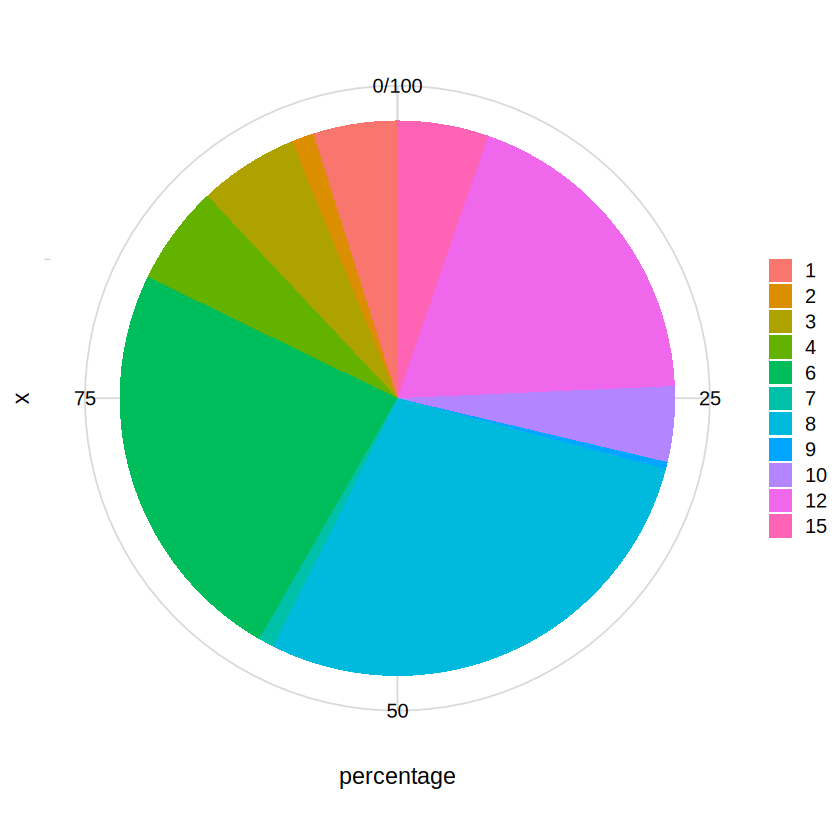

In [18]:
df <- data.frame(
    year = unique(processed_data$Genre),
    percentage = c(t(as.data.frame(cat_col_info_df$value_ratios[[2]])[1, ]))
)

bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
geom_bar(width = 1, stat = "identity")
pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
pie

### Thử xử lý dữ liệu bị thiếu bằng PCA

Tham khảo từ bài báo **[Principal component analysis with missing values: a comparative survey of methods](https://link.springer.com/article/10.1007/s11258-014-0406-z)** của Julie Josse và Stéphane Dray.

In [19]:
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie             : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year              : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings           : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre             : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross             : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget            : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens           : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel            : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment         : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views             : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes             : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes          : num [1:231] 425 61 34 132 610 7 419 197 41

In [20]:
# Ước lượng thành phần chính
nPCs <- estim_ncpPCA(raw_data[, -c(1)])
print(nPCs)

$ncp
[1] 2

$criterion
           0            1            2            3            4            5 
8.461633e+14 6.896501e+14 3.453184e+14 4.072345e+14 4.950558e+14 5.955508e+14 



In [21]:
# Xử lý missing value
processed_data <- imputePCA(raw_data[, -c(1)], ncp = nPCs$ncp, scale = TRUE)
processed_data <- processed_data$completeObs

In [22]:
print(apply(processed_data, 2, function(x) {sum(is.na(x))/length(x)*100}))

              Year            Ratings              Genre              Gross 
                 0                  0                  0                  0 
            Budget            Screens             Sequel          Sentiment 
                 0                  0                  0                  0 
             Views              Likes           Dislikes           Comments 
                 0                  0                  0                  0 
AggregateFollowers 
                 0 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 35 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


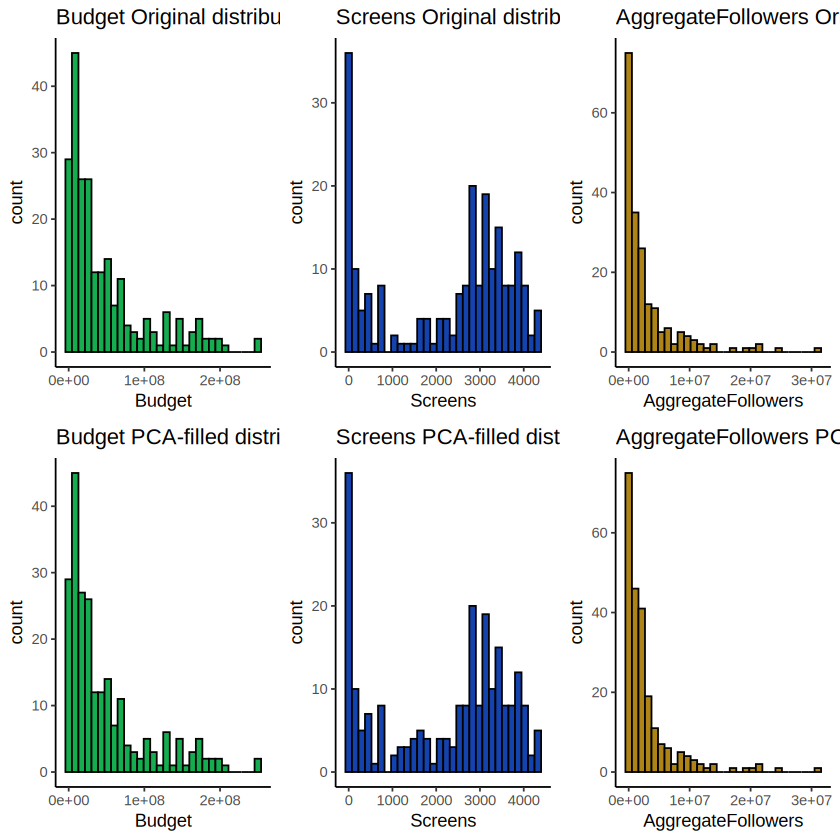

In [23]:
# Trực quan phân phối trước và sau khi fill missing value

h1 <- ggplot(raw_data, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget Original distribution") +
  theme_classic()
h2 <- ggplot(raw_data, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens Original distribution") +
  theme_classic()
h3 <- ggplot(raw_data, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers Original distribution") +
  theme_classic()

  
h4 <- ggplot(processed_data, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget PCA-filled distribution") +
  theme_classic()
h5 <- ggplot(processed_data, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens PCA-filled distribution") +
  theme_classic()
h6 <- ggplot(processed_data, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers PCA-filled distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, h5, h6, nrow = 2, ncol = 3, rel_widths = c(1, 1), rel_heights = c(1, 1))

Đến đây, ta thấy PCA fill missing value rất tốt. Ta sẽ sử dụng nó.

## Xử lý đa cộng tuyến

In [24]:
# Một số việc tiền xử lý trước: chuyển đổi sang dataframe, lọc các giá trị 0

processed_data_final <- as.data.frame(processed_data)
processed_data_final <- processed_data_final %>% filter(Likes != 0)
processed_data_final <- processed_data_final %>% filter(Dislikes != 0)
processed_data_final <- processed_data_final %>% filter(Comments != 0)

processed_data_final <- processed_data_final[,-c(1)] # Loại bỏ cột tên phim

In [25]:
# Kiểm tra tình trạng đa cộng tuyến của dữ liệu
model <- lm(Gross ~ ., data = processed_data_final)

vif_values <- vif(model)
print(vif_values)

# Interpret the results
if(any(vif_values > 5)) {
  cat("Warning: High multicollinearity detected.\n")
} else {
  cat("No high multicollinearity detected.\n")
}

           Ratings              Genre             Budget            Screens 
          1.289307           1.124556           2.187603           1.746405 
            Sequel          Sentiment              Views              Likes 
          1.386263           1.052457           3.902643           7.985188 
          Dislikes           Comments AggregateFollowers 
          3.122693           8.629857           1.136308 


In [26]:
# Gọi hàm xử lý đa cộng tuyến
cleaned_df <- remove_high_vif ("Gross", processed_data_final, threshold = 6)

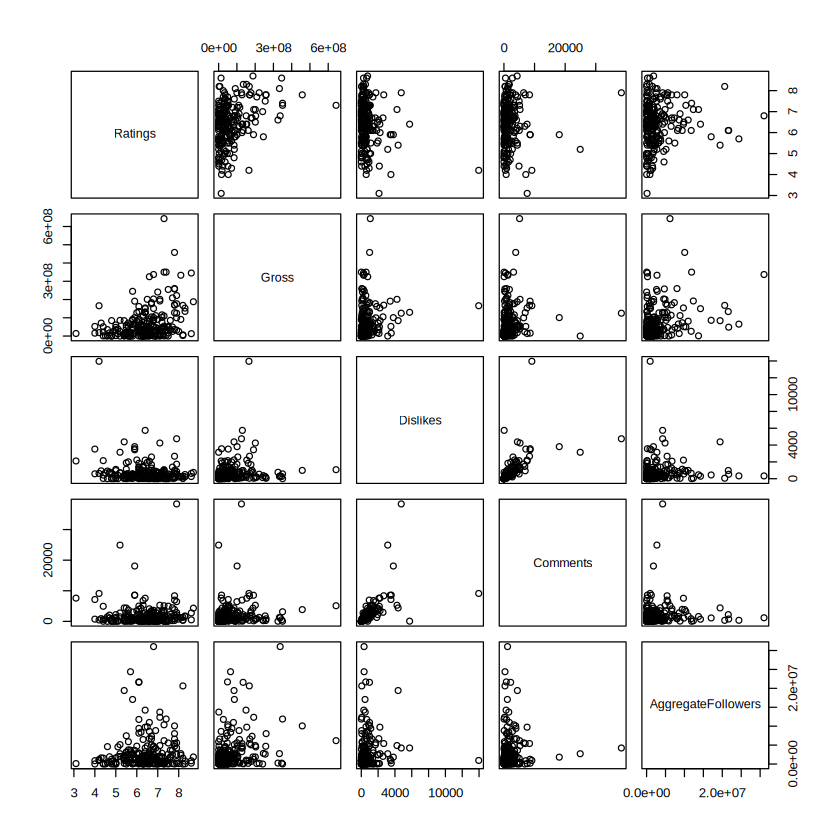

In [27]:
# Trực quan phân phối
plot(cleaned_df)

## Khảo sát ngoại lai

In [28]:
# Ở đây sử dụng IQR để loại bỏ ngoại lai
Q1 <- quantile(cleaned_df$'Gross', 0.25)
Q3 <- quantile(cleaned_df$'Gross', 0.75)
IQR <- Q3 - Q1
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR
outliers <- which(cleaned_df$'Gross' < lower_bound | cleaned_df$'Gross' > upper_bound)
outliers

cleaned_df <- cleaned_df[-outliers, ]
# dim(cleaned_df)
# dim(df_cleaned)

[1]  11  19  26  27  46  69 123 126 132 147 159 160 161 162 163

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

In [29]:
names(cleaned_df)

[1] "Ratings"            "Gross"              "Dislikes"          
[4] "Comments"           "AggregateFollowers"

### Phân tích biến `Gross`

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


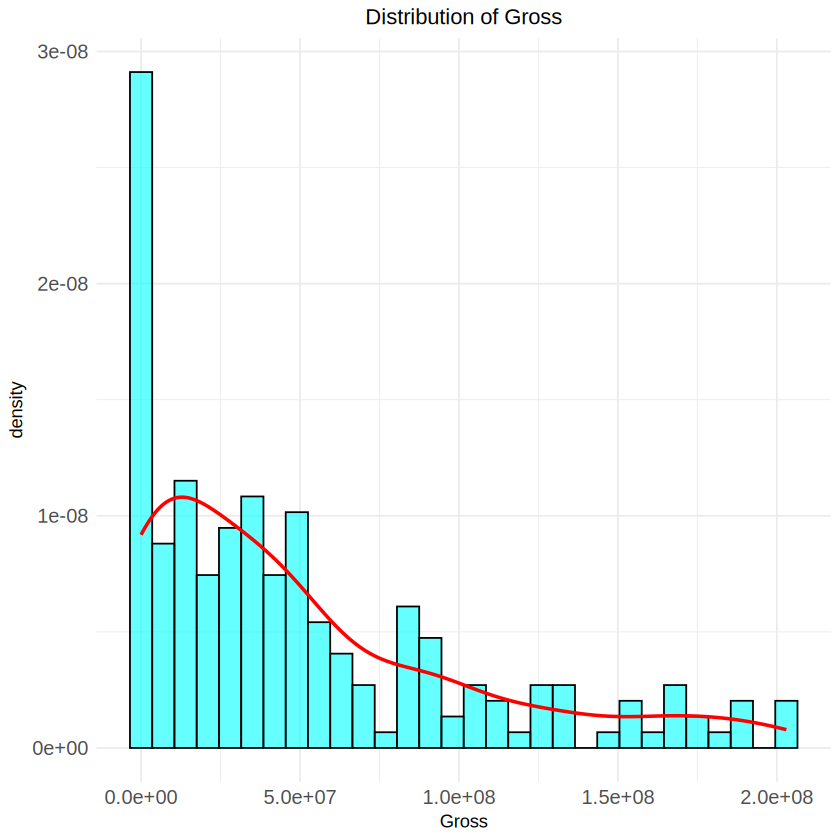

In [30]:
# tidy_empirical(train$Gross) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**:
- Nhìn vào biểu đồ, ta thấy phân phối của biến `Gross` bị lệch phải.

Ta thử sử dụng log-transform nó.

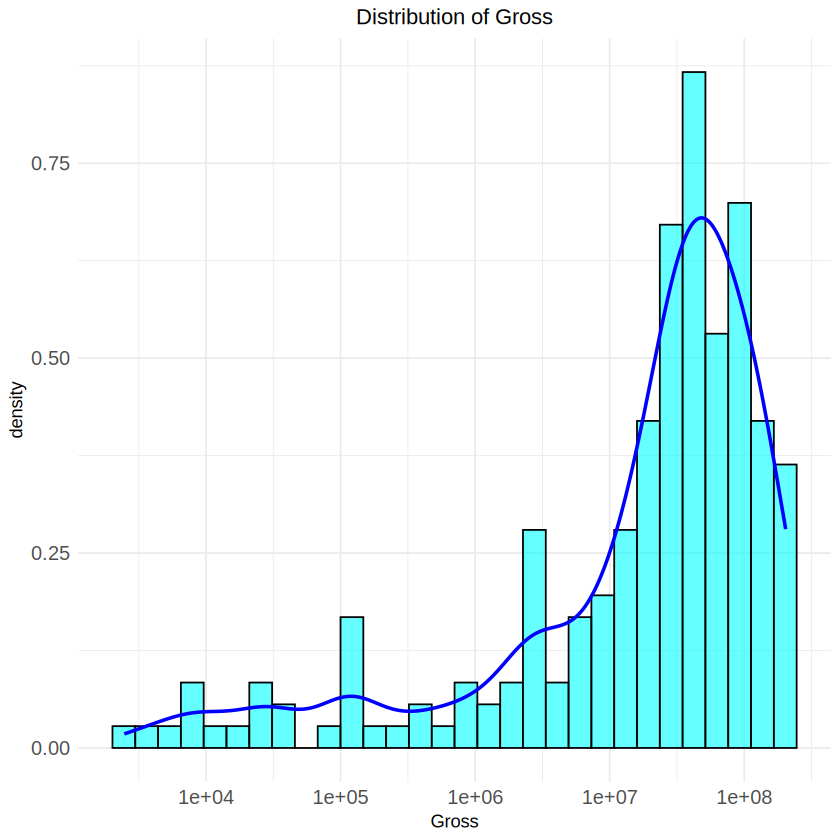

In [31]:
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Ta nhận thấy sau khi sử dụng log-transform, dữ liệu bị lệch trái. Do đó, ta thử sử dụng box-cox.

[1] "Optimal lambda:  0.303030303030303"


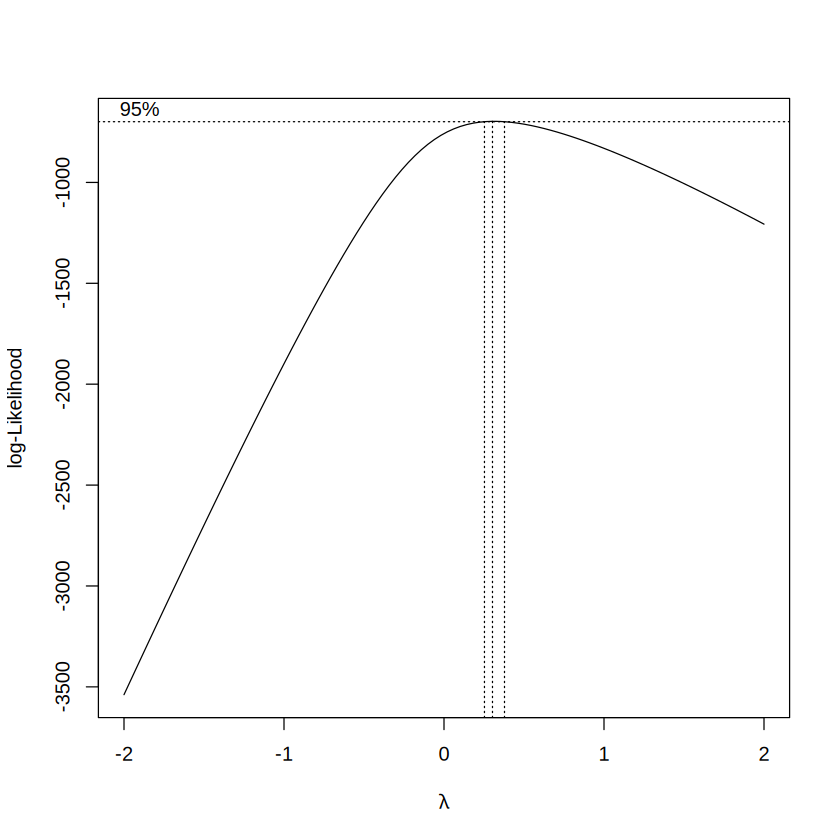

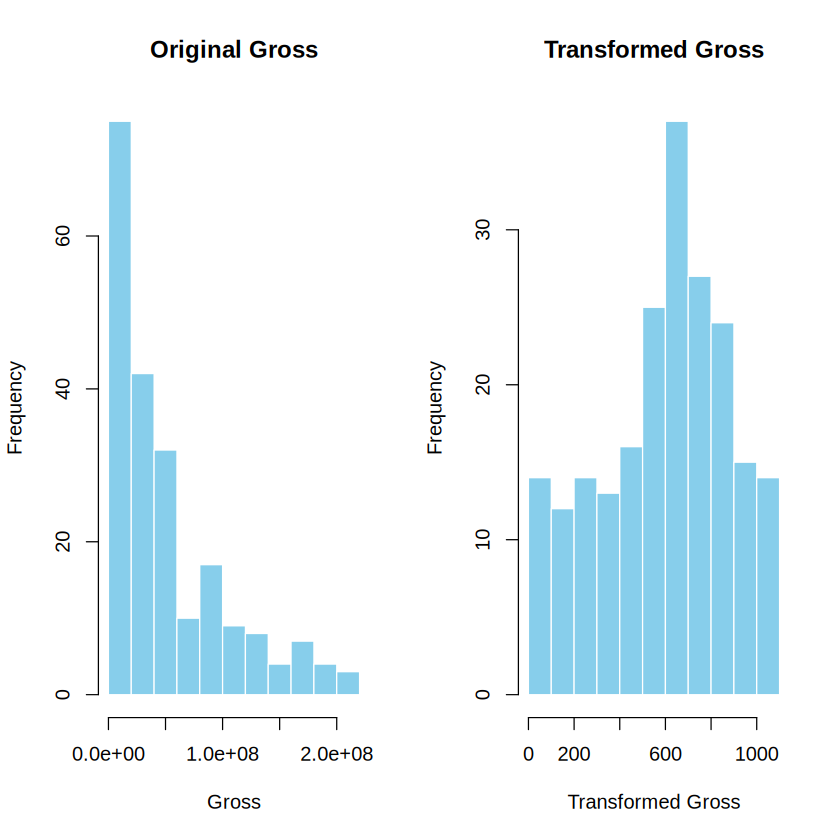

In [32]:
response_variable <- cleaned_df$Gross 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Gross", xlab = "Gross", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Gross", xlab = "Transformed Gross", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

Ta có được giá trị lambda tối ưu là 0.33 và sử dụng giá trị này để biến đổi biến `Gross`. Biểu đồ histogram phía bên dưới thể hiện phân phối của biến này trước và sau khi biến đổi. Dễ dàng thấy được, sau khi biến đổi, biến này đã tương đối chuẩn hơn.

Ta thực hiện gán giá trị đã được biến đổi vào dataframe.

In [33]:
cleaned_df$Gross <- transformed_response

### Phân tích biến `Dislikes`

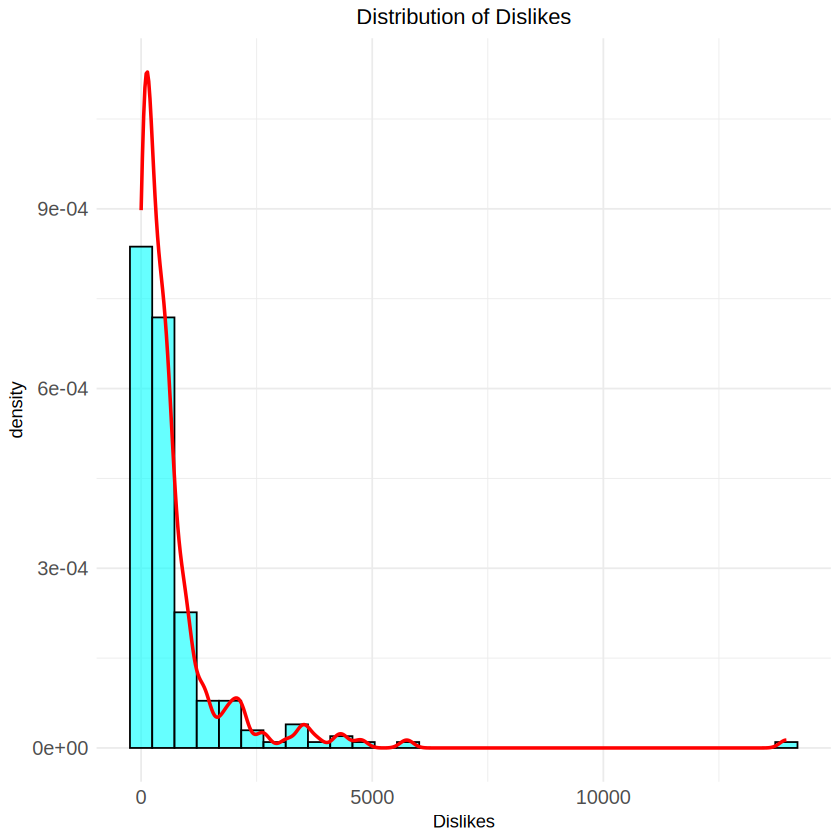

In [34]:
# tidy_empirical(train$Dislikes) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Dislikes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Dislikes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**
- Phân phối của biến `Dislikes` bị lệch trái.

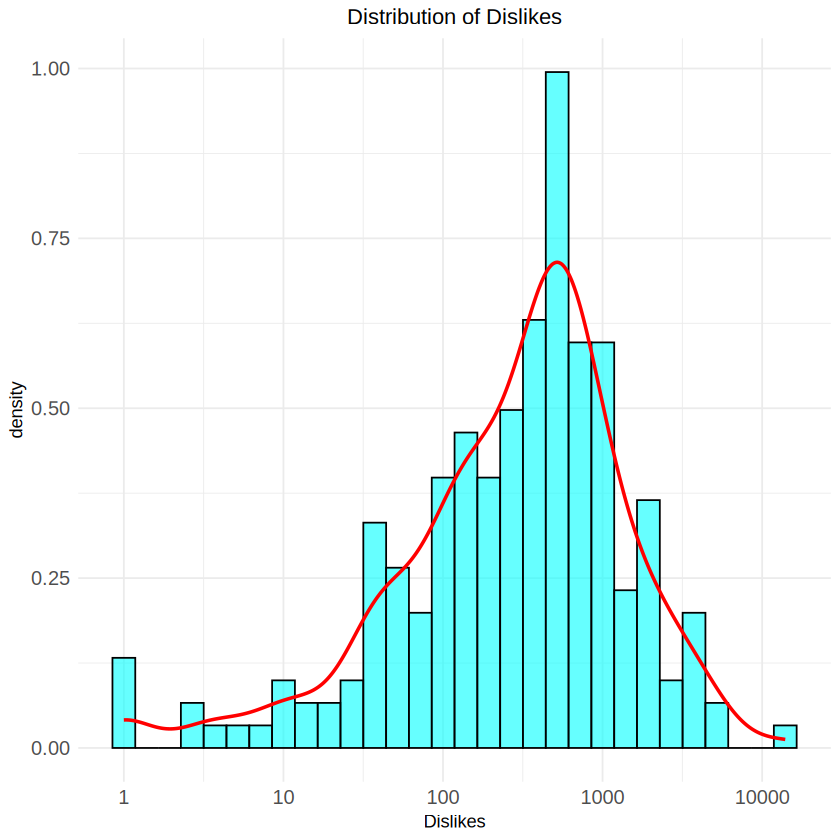

In [35]:
ggplot(cleaned_df, aes(x = Dislikes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of Dislikes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**
- Khi dùng log-scale, phân phối của biến `Dislikes` đã xấp xỉ chuẩn hơn.
- Ta có thể dùng box-cox để biến đổi dữ liệu nhờ vào việc tìm lambda tối ưu.

[1] "Optimal lambda:  0.181818181818182"


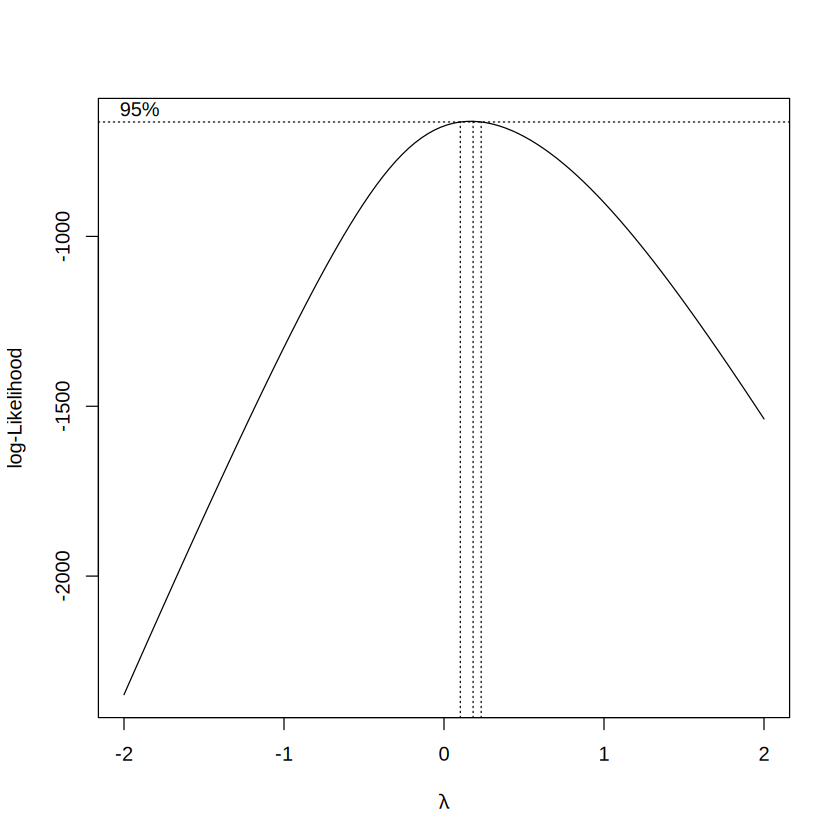

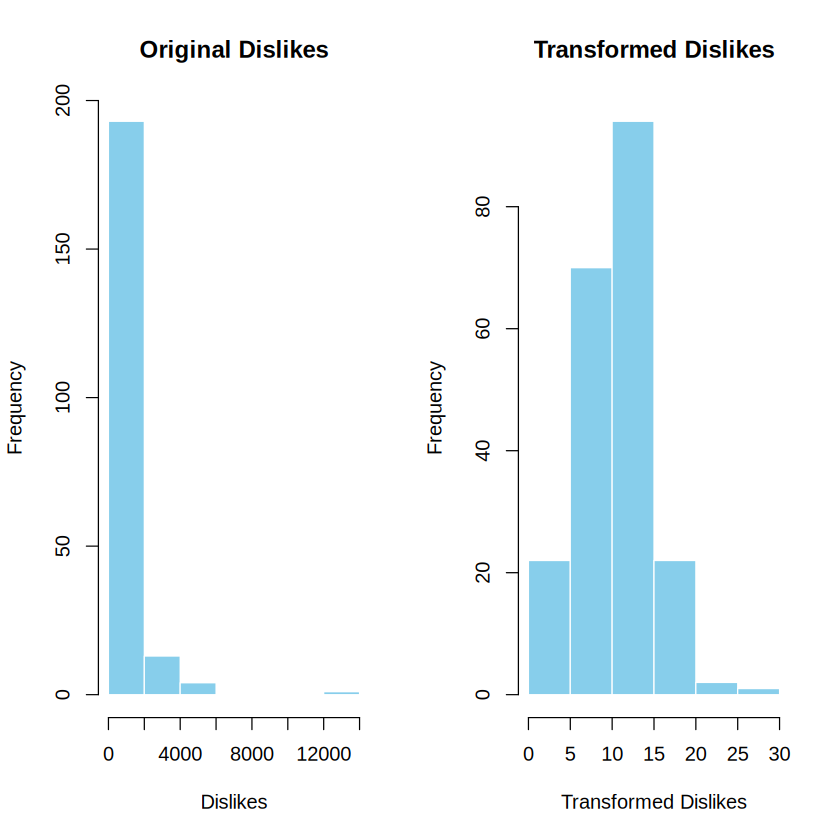

In [36]:
response_variable <- cleaned_df$Dislikes[cleaned_df$Dislikes != 0]
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Dislikes", xlab = "Dislikes", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Dislikes", xlab = "Transformed Dislikes", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `Dislikes` đã tương đối chuẩn hơn.

In [37]:
cleaned_df$Dislikes <- (cleaned_df$Dislikes^optimal_lambda - 1) / optimal_lambda

### Phân tích biến `Comments`

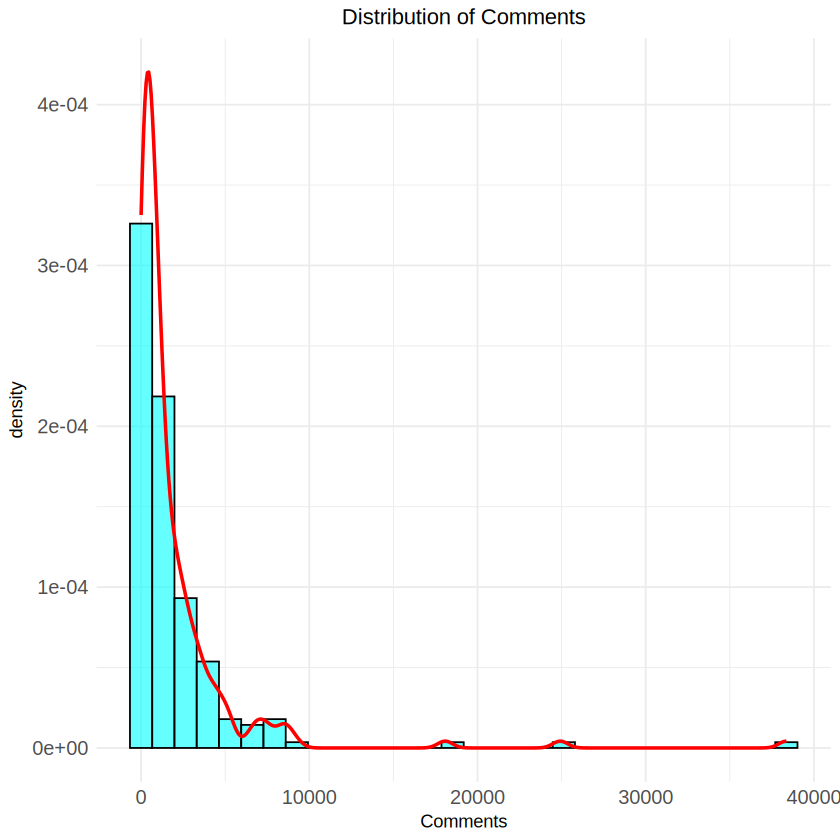

In [38]:
# tidy_empirical(train$Comments) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Comments)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Comments") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )


**Nhận xét**
- Phân phối của biến `Comments` bị lệch trái.

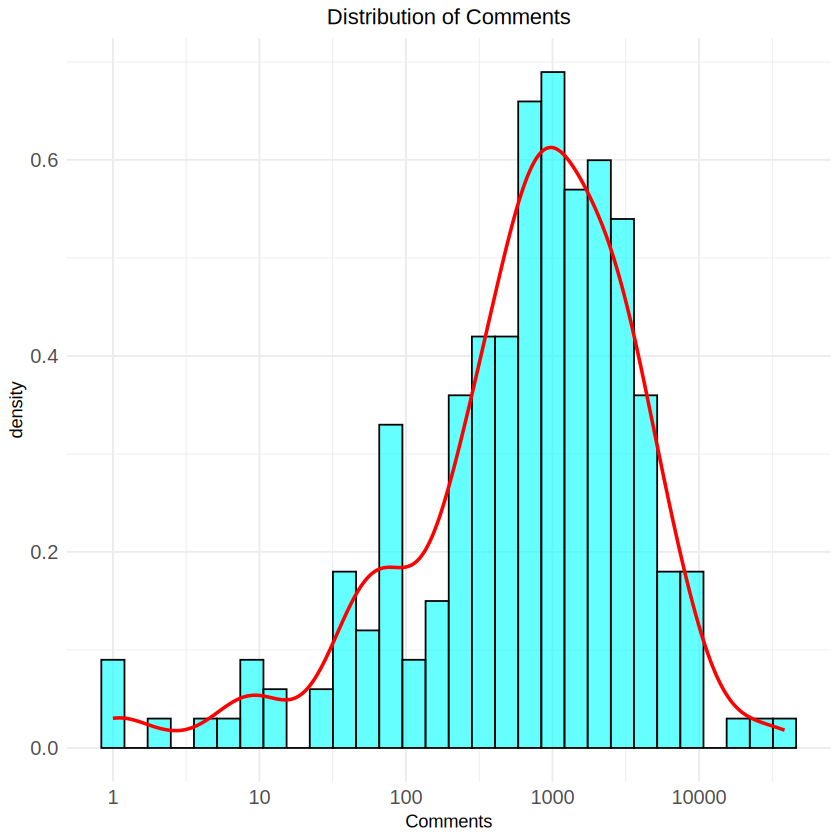

In [39]:
ggplot(cleaned_df, aes(x = Comments)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of Comments") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**
- Khi dùng log-scale, phân phối của biến `Comments` đã xấp xỉ chuẩn hơn.
- Ta có thể dùng box-cox để biến đổi dữ liệu nhờ vào việc tìm lambda tối ưu.

[1] "Optimal lambda:  0.181818181818182"


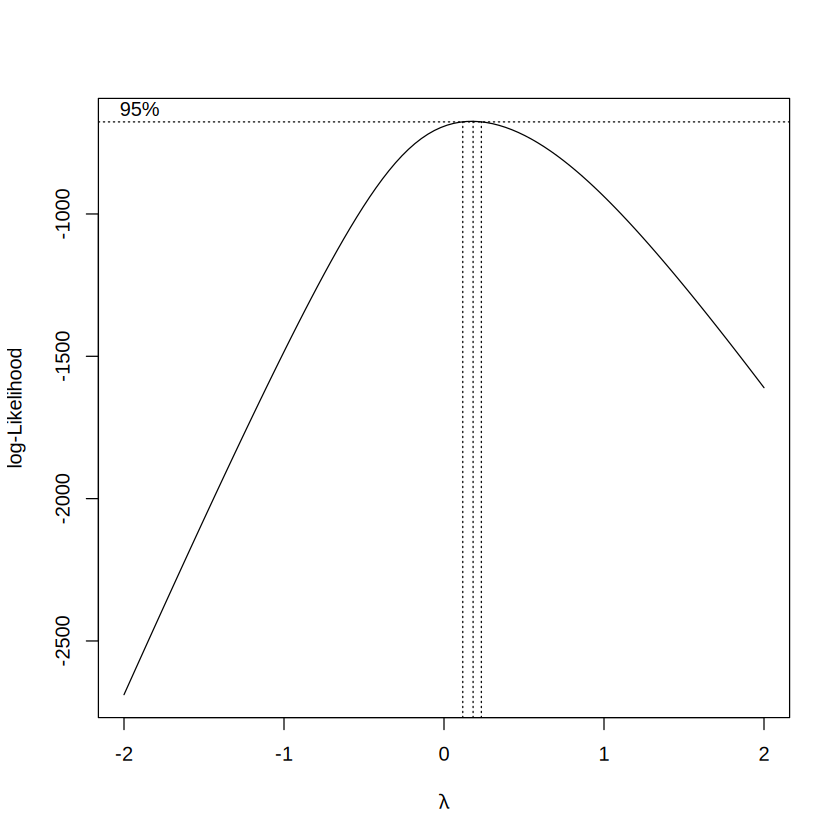

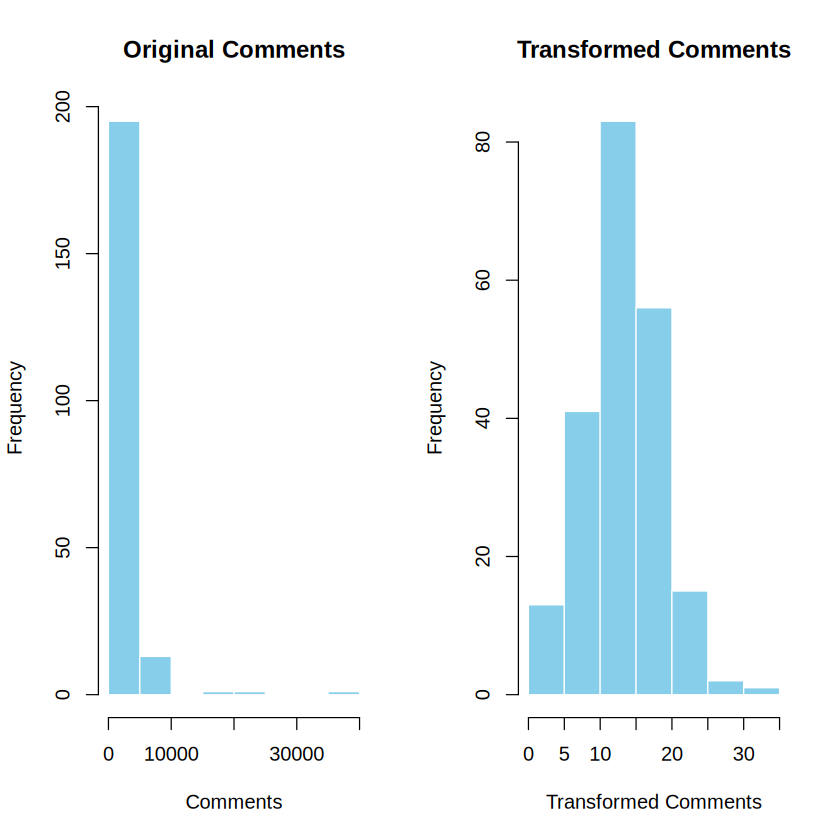

In [40]:
response_variable <- cleaned_df$Comments[cleaned_df$Comments != 0]
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Comments", xlab = "Comments", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Comments", xlab = "Transformed Comments", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `Comments` đã tương đối chuẩn hơn.

In [41]:
cleaned_df$Comments <- (cleaned_df$Comments^optimal_lambda - 1) / optimal_lambda

### Phân tích biến `AggregateFollowers`

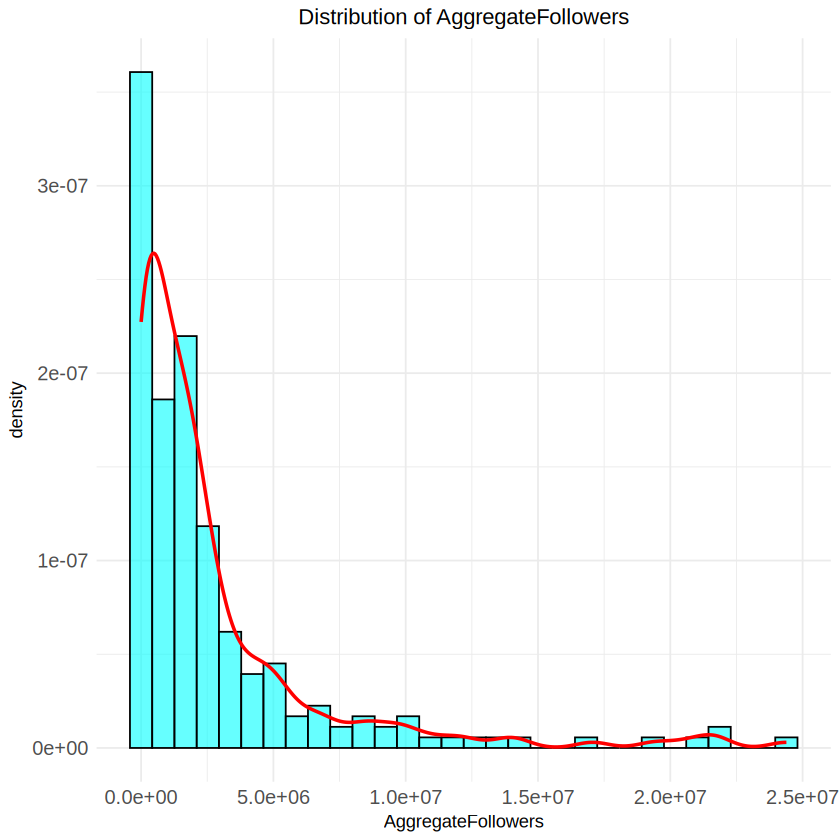

In [42]:
# tidy_empirical(train$AggregateFollowers) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**
- Phân phối của biến `AggregateFollowers` bị lệch trái.

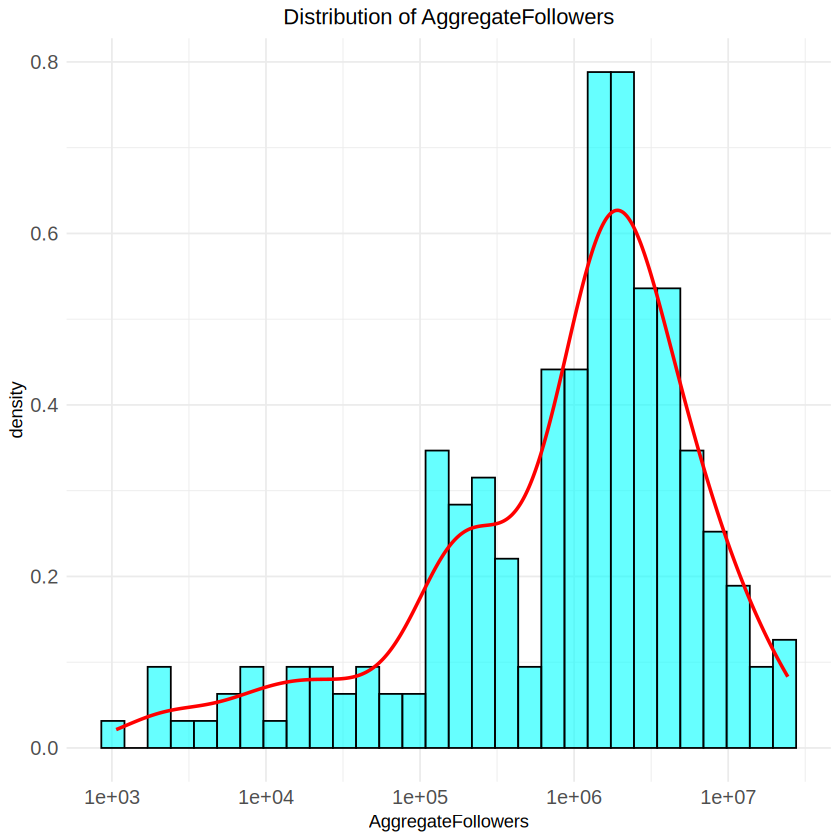

In [43]:
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**
- Khi dùng log-scale, phân phối của biến `AggregateFollowers` đã xấp xỉ chuẩn hơn.
- Ta có thể dùng box-cox để biến đổi dữ liệu nhờ vào việc tìm lambda tối ưu.

[1] "Optimal lambda:  0.181818181818182"


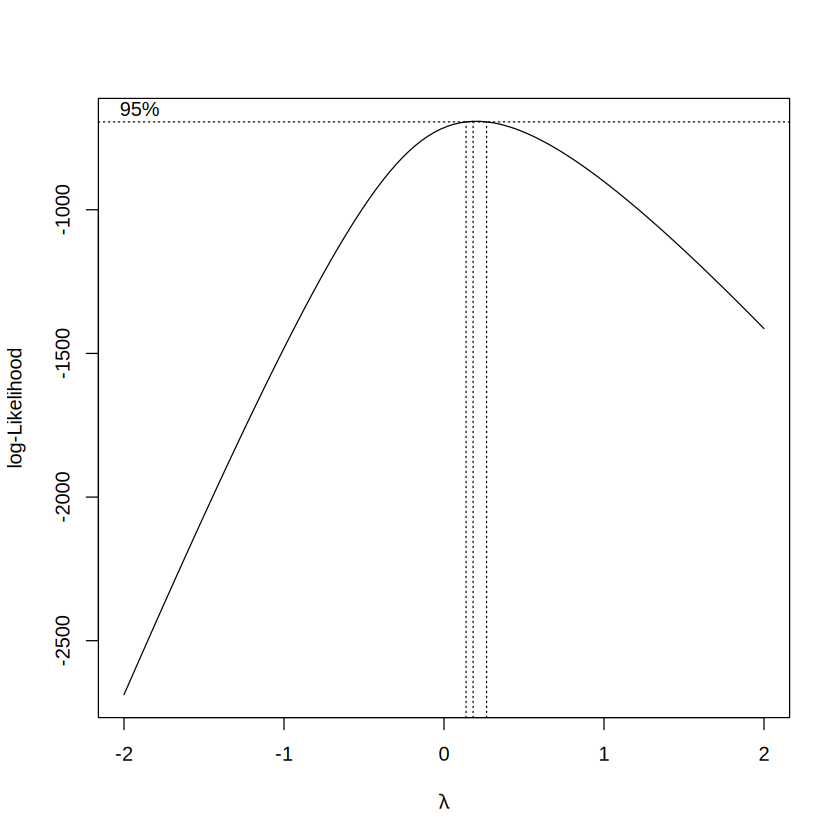

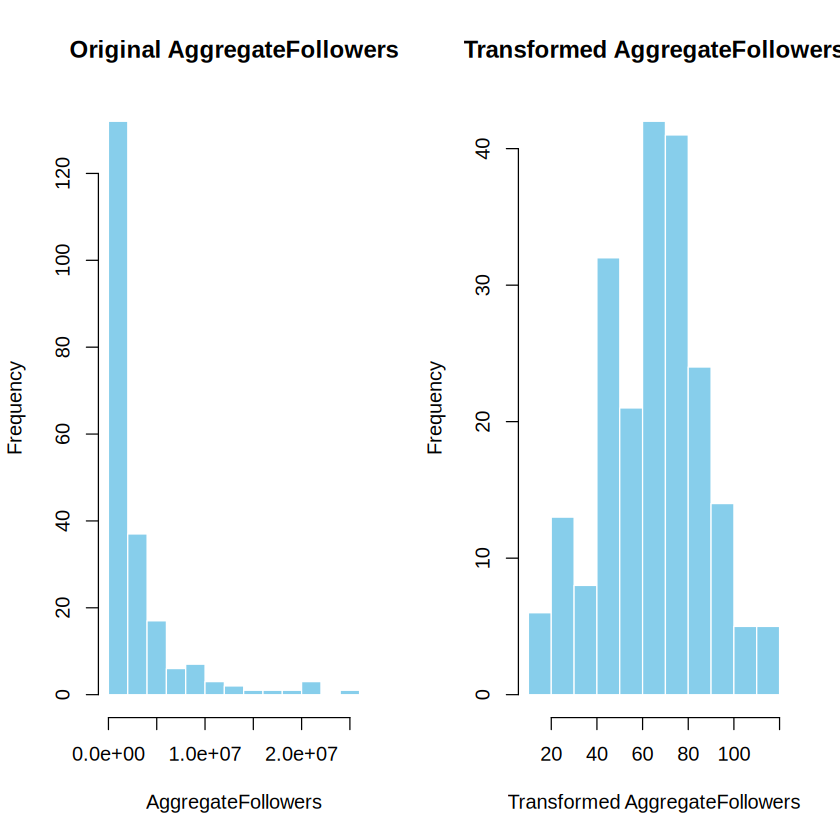

In [44]:
response_variable <- cleaned_df$AggregateFollowers
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original AggregateFollowers", xlab = "AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed AggregateFollowers", xlab = "Transformed AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `AggregateFollowers` đã tương đối chuẩn hơn.

In [45]:
cleaned_df$AggregateFollowers <- (cleaned_df$AggregateFollowers^optimal_lambda - 1) / optimal_lambda

## Phân chia tập dữ liệu

Ở đây, ta phân chia dữ liệu thành hai tập: train (80%) và test (20%).

In [46]:
split_ratio <- 0.8
split_index <- floor(nrow(cleaned_df) * split_ratio)

train = cleaned_df[1:split_index,]
test = cleaned_df[(split_index + 1):nrow(cleaned_df),]

In [47]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 168   5

In [48]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 43  5

In [49]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	168 obs. of  5 variables:
 $ Ratings           : num  6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Gross             : num  49 1065 610 889 512 ...
 $ Dislikes          : num  11.03 6.11 4.94 7.86 12.15 ...
 $ Comments          : num  12.29 8.72 5.58 12.05 14.09 ...
 $ AggregateFollowers: num  63.7 101.6 53.9 55.7 70.9 ...


## Mô hình hóa

### Khảo sát sự tương quan giữa các biến

In [50]:
# round(cor(train[, c(1:13)]), 2)
round(cor(train), 2)

,Ratings,Gross,Dislikes,Comments,AggregateFollowers
Ratings,1.00,0.21,-0.07,0.13,0.11
Gross,0.21,1.00,0.42,0.41,0.27
Dislikes,-0.07,0.42,1.00,0.87,0.27
Comments,0.13,0.41,0.87,1.00,0.23
AggregateFollowers,0.11,0.27,0.27,0.23,1.00


Một số nhận xét:
- Biến `Ratings` và biến `AggregateFollowers` có tương quan với biến `Gross` cao, lần lượt 0.21 và 0.27
- Các biến `Dislikes` và `Comments` có tương quan với biến `Gross` cao hơn hai biến còn lại, 0.42 và 0.41
- Biến `Comments` có tương quan thuận, mạnh với biến `Dislikes`, 0.87
- Biến `Comments` có tương quan thuận, yếu với biến `Ratings`, 0.13
- Biến `Comments` có tương quan thuận, vừa với biến `AggregateFollowers`, 0.23
- Biến `Dislikes` có tương quan nghịch, yếu với biến `Ratings`, -0.07

### Xây dựng mô hình đầy đủ

In [51]:
str(train)

'data.frame':	168 obs. of  5 variables:
 $ Ratings           : num  6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Gross             : num  49 1065 610 889 512 ...
 $ Dislikes          : num  11.03 6.11 4.94 7.86 12.15 ...
 $ Comments          : num  12.29 8.72 5.58 12.05 14.09 ...
 $ AggregateFollowers: num  63.7 101.6 53.9 55.7 70.9 ...


In [52]:
full.lm <- lm(Gross ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = Gross ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-694.57 -159.46   40.74  176.82  525.15 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)        -233.15453  155.56097  -1.499  0.13586   
Ratings              69.40367   23.14014   2.999  0.00313 **
Dislikes             27.27097   10.33054   2.640  0.00910 **
Comments              0.06128    8.04856   0.008  0.99393   
AggregateFollowers    1.87503    0.95312   1.967  0.05085 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 256.9 on 163 degrees of freedom
Multiple R-squared:  0.2558,	Adjusted R-squared:  0.2376 
F-statistic: 14.01 on 4 and 163 DF,  p-value: 7.597e-10



### Lựa chọn model tốt nhất

Với số lượng lớn các yếu tố dự đoán, điều quan trọng là phải giảm thiểu mô hình bằng cách chỉ bao gồm các yếu tố dự đoán hữu ích. Có tất cả 6 yếu tố dự đoán trong tập dữ liệu, nghĩ là có thể có $2^{4}$ mô hình hồi quy. Để chọn mô hình một cách hiệu quả, việc lựa chọn lùi được thực hiện bằng sử dụng step function. Phương pháp này lặp lại các quy trình để giảm thiểu Akaike’s Information Criteria (AIC) và Bayesian Information Criteria (BIC). Lựa chọn mô hình ngược so với lựa chọn tiến vì nó loại bỏ khả năng một yếu tố dự đoán mới được chọn có khả năng tương tự hoặc nhiều hơn để giải thích các phần của phản hồi đã được giải thích bởi một yếu tố dự đoán khác có trong mô hình.

In [53]:
# Mô hình chặn dưới
model.lb <- lm(Gross ~ 1, data = train) 

In [54]:
# Mô hình chặn trên
model.up <- full.lm

In [55]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = Gross ~ Ratings + Dislikes + AggregateFollowers, 
    data = train)

Coefficients:
       (Intercept)             Ratings            Dislikes  AggregateFollowers  
          -233.482              69.474              27.341               1.874  


In [56]:
csm_models<- regsubsets(Gross ~  Ratings + Dislikes + AggregateFollowers, data = train)
summary.csm<-summary(csm_models)

In [57]:
# Lựa chọn mô hình tốt nhất từ reg subsets 
summary.csm$which

,(Intercept),Ratings,Dislikes,AggregateFollowers
1,TRUE,FALSE,TRUE,FALSE
2,TRUE,TRUE,TRUE,FALSE
3,TRUE,TRUE,TRUE,TRUE


Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [58]:
summary.csm$rsq

[1] 0.1798988 0.2380751 0.2558313

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [59]:
# model with largest adjusted R^2 
summary.csm$adjr2

[1] 0.1749584 0.2288396 0.2422184

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [60]:
# model with smallest Mallow's Cp
summary.csm$cp

[1] 16.734016  5.913117  4.000000

#### Chọn mô hình tốt nhất dựa trên BIC

In [61]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.csm$bic

[1] -23.07109 -30.30853 -29.14605

In [62]:
best_model_index <- which.min(summary.csm$bic)
best_model <- summary.csm$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

       (Intercept)            Ratings           Dislikes AggregateFollowers 
              TRUE               TRUE               TRUE              FALSE 
[1] "Ratings"  "Dislikes"


In [63]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("Gross ~", paste(best_vars, collapse = " + "))
best_model_csm <- lm(as.formula(formula_str), data=train)

In [64]:
# Tóm tắt mô hình
summary(best_model_csm)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-688.10 -164.64   32.01  195.17  542.50 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -174.677    147.318  -1.186 0.237439    
Ratings       75.062     21.148   3.549 0.000503 ***
Dislikes      29.984      4.633   6.472 1.06e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 258.4 on 165 degrees of freedom
Multiple R-squared:  0.2381,	Adjusted R-squared:  0.2288 
F-statistic: 25.78 on 2 and 165 DF,  p-value: 1.81e-10


Như vậy, ta thu được mô hình

```
Gross ~ -174.677 * (Intercept) + 75.062 * Ratings + 29.984 * Dislikes
```

Điều này có ý nghĩa là, biến `Gross` sẽ được giải thích thông qua hai biến `Ratings` và `Dislikes` 
- Điểm xếp hạng càng cao thì doanh thu của một bộ phim cũng cao (hợp lý theo logic thông thường).
- Số lượt chê càng cao thì doanh thu của một bộ phim cũng cao. Điều này có thể lý giải, khi một bộ phim có nhiều bình luận tiêu cực, người ta sẽ có hứng thú đi xem nó để biết tại sao nó bị chê (yếu tố tò mò).

Bây giờ, ta sẽ đi phân tích xem mô hình này có thỏa những giả định của mô hình hồi quy bội hay không?

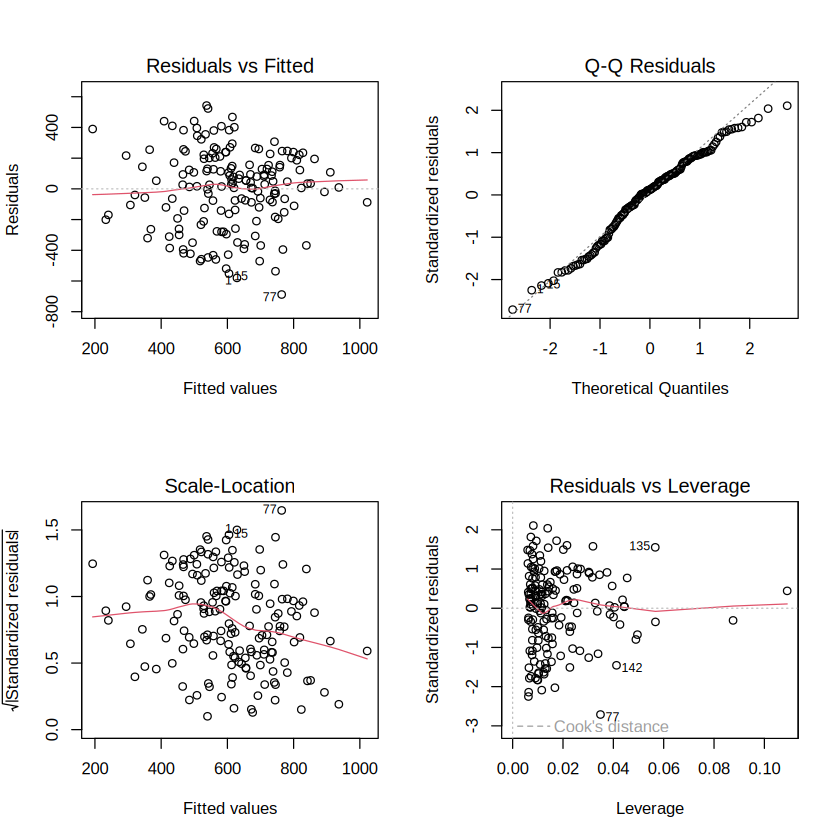

In [65]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_csm)

#### Phân tích Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

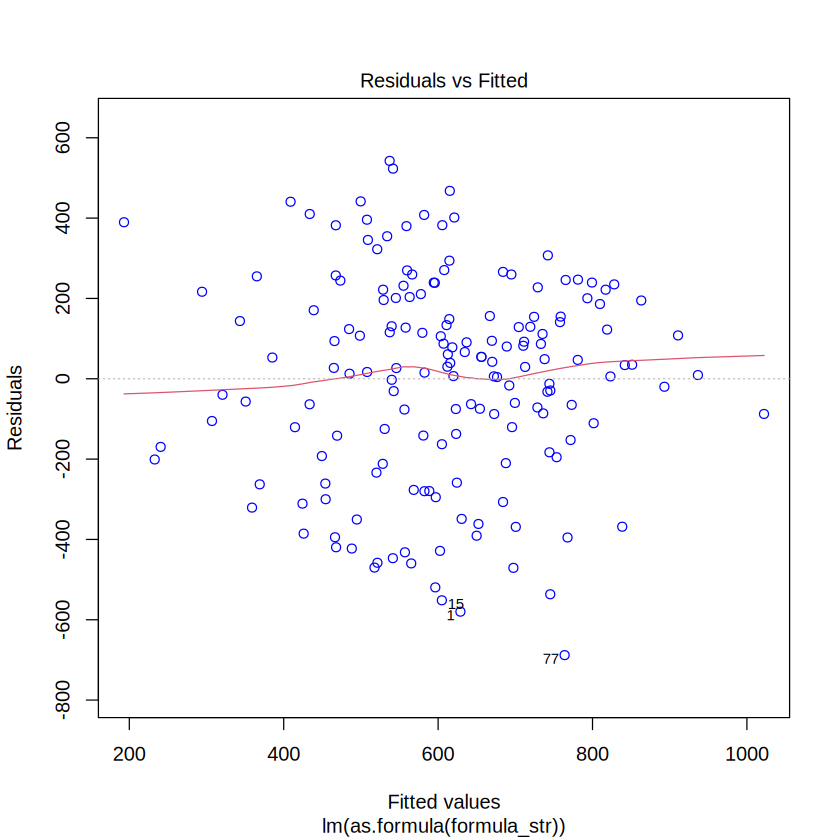

In [66]:
plot(best_model_csm, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Phân tích Normal Q–Q (quantile-quantile) Plot

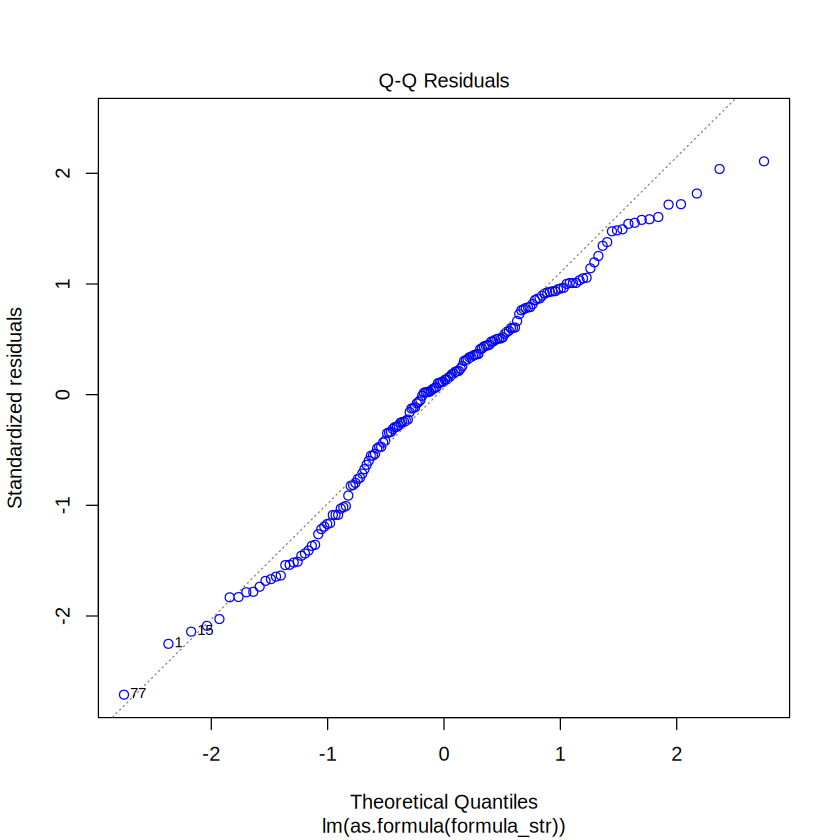

In [67]:
plot(best_model_csm, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [68]:
# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm))


	Shapiro-Wilk normality test

data:  residuals(best_model_csm)
W = 0.98029, p-value = 0.0172


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Phân tích Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

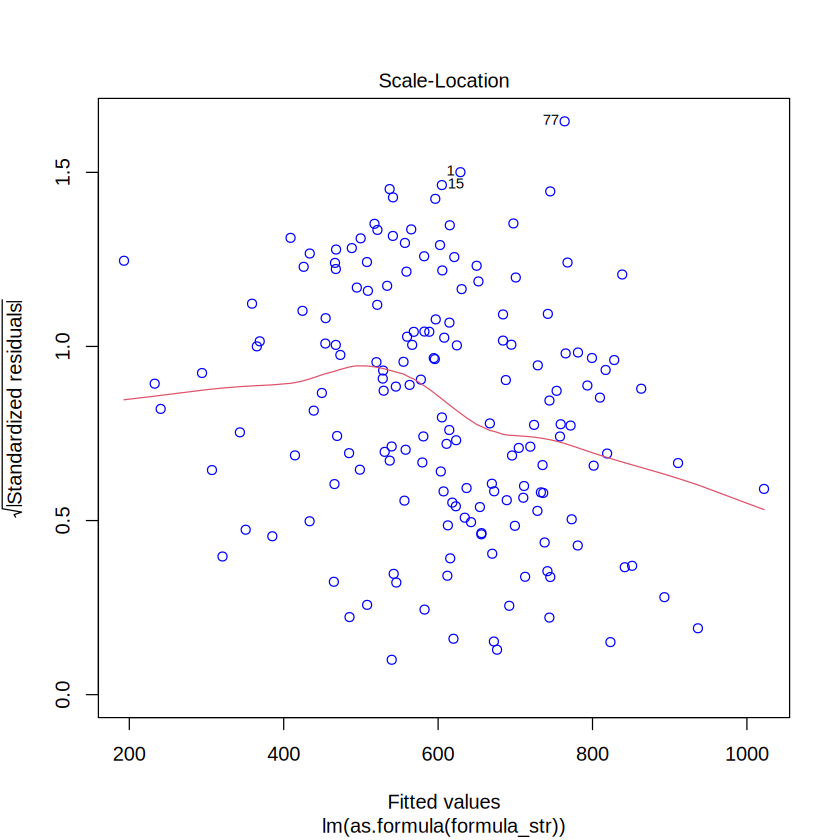

In [69]:
plot(best_model_csm, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [70]:
# Breusch-Pagan Test
bptest(best_model_csm)


	studentized Breusch-Pagan test

data:  best_model_csm
BP = 6.1352, df = 2, p-value = 0.04653


Như vậy, ta thấy p-value nhỏ hơn múc ý nghĩa 0.05, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là homoscedastic

#### Phân tích Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

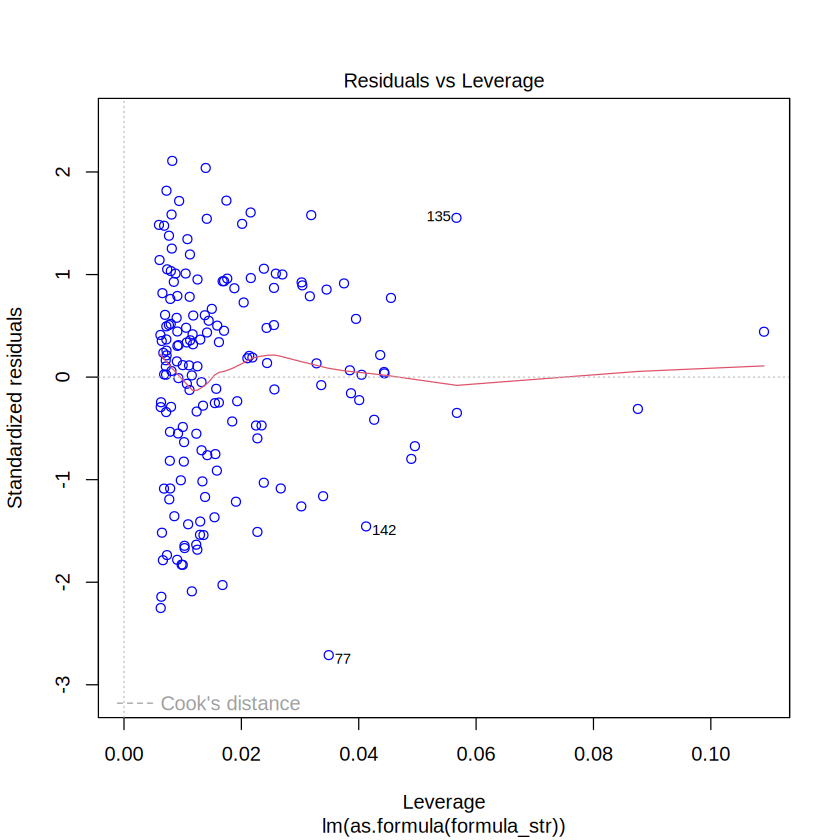

In [71]:
plot(best_model_csm, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

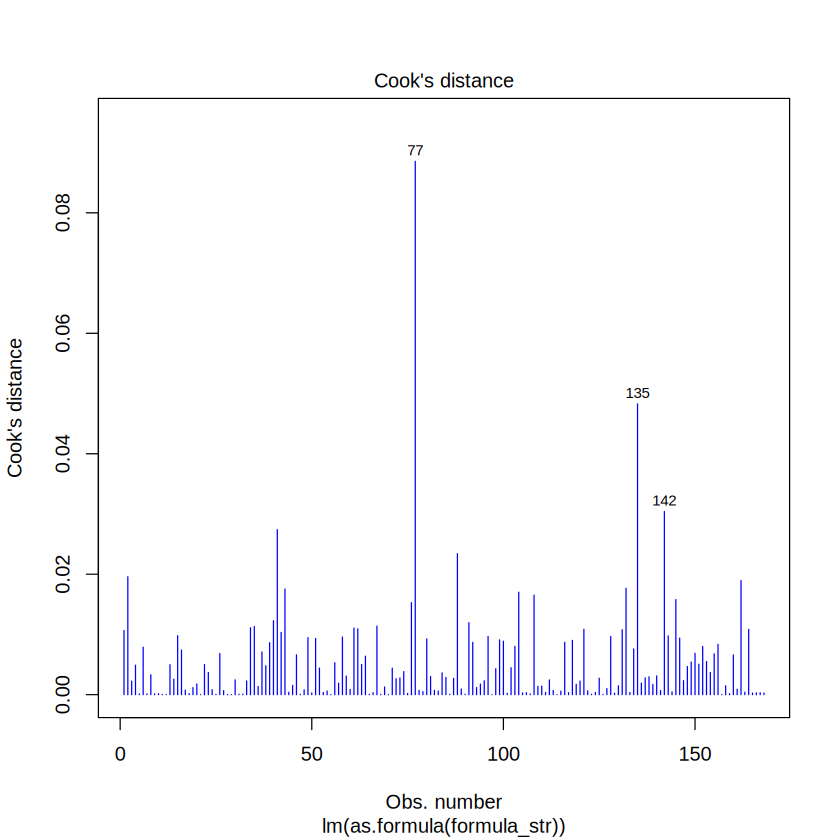

In [72]:
plot(best_model_csm, which=4, col=c("blue"))

Kết luận:
- Mô hình thu được có thể được sử dụng để đem đi dự đoán.

### Loại bỏ ngoại lai dựa trên Cook'Distance

In [73]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.02380952

In [74]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_csm)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_csm.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_csm.2)

# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm.2))

# Breusch-Pagan Test
bptest(best_model_csm.2)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-585.15 -148.79   21.57  185.12  551.74 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -217.195    148.501  -1.463 0.145532    
Ratings       75.476     21.314   3.541 0.000521 ***
Dislikes      34.079      4.625   7.369 8.48e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 249.8 on 161 degrees of freedom
Multiple R-squared:  0.2817,	Adjusted R-squared:  0.2728 
F-statistic: 31.57 on 2 and 161 DF,  p-value: 2.712e-12



	Shapiro-Wilk normality test

data:  residuals(best_model_csm.2)
W = 0.98463, p-value = 0.06694



	studentized Breusch-Pagan test

data:  best_model_csm.2
BP = 11.526, df = 2, p-value = 0.003142


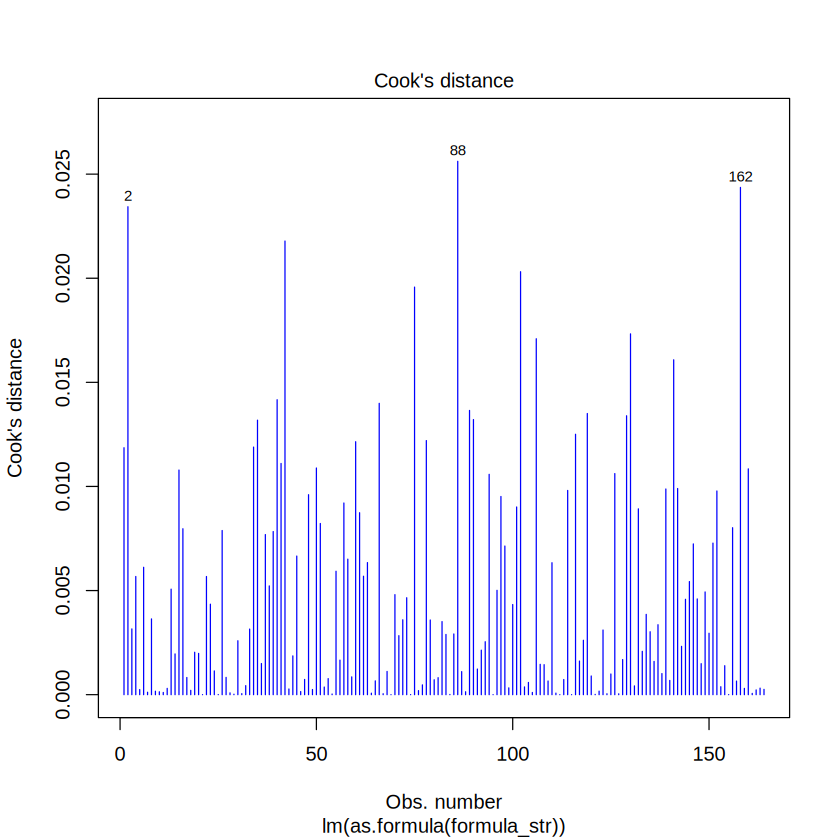

In [75]:
plot(best_model_csm.2, which=4, col=c("blue"))

In [76]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_csm.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_csm.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_csm.3)

# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm.3))

# Breusch-Pagan Test
bptest(best_model_csm.3)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-686.67 -169.10   33.81  198.00  543.17 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -168.229    148.538  -1.133 0.259060    
Ratings       74.171     21.323   3.478 0.000647 ***
Dislikes      29.807      4.675   6.375  1.8e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 259.7 on 163 degrees of freedom
Multiple R-squared:  0.234,	Adjusted R-squared:  0.2246 
F-statistic:  24.9 on 2 and 163 DF,  p-value: 3.657e-10



	Shapiro-Wilk normality test

data:  residuals(best_model_csm.3)
W = 0.98056, p-value = 0.01974



	studentized Breusch-Pagan test

data:  best_model_csm.3
BP = 5.7883, df = 2, p-value = 0.05535


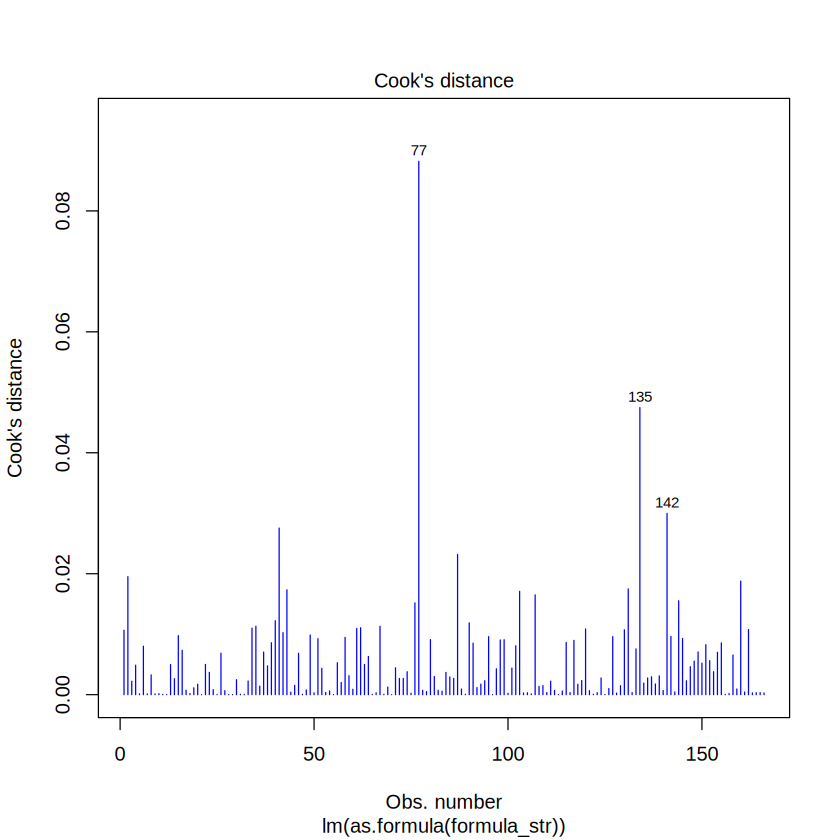

In [77]:
plot(best_model_csm.3, which=4, col=c("blue"))

In [78]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_csm.3)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_csm.4 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_csm.4)

# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm.4))

# Breusch-Pagan Test
bptest(best_model_csm.4)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-586.27 -153.21   21.53  191.18  547.03 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -145.457    144.725  -1.005   0.3164    
Ratings       66.880     20.956   3.191   0.0017 ** 
Dislikes      32.586      4.583   7.111 3.56e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 251.7 on 161 degrees of freedom
Multiple R-squared:  0.2675,	Adjusted R-squared:  0.2584 
F-statistic:  29.4 on 2 and 161 DF,  p-value: 1.306e-11



	Shapiro-Wilk normality test

data:  residuals(best_model_csm.4)
W = 0.98371, p-value = 0.0515



	studentized Breusch-Pagan test

data:  best_model_csm.4
BP = 13.14, df = 2, p-value = 0.001402


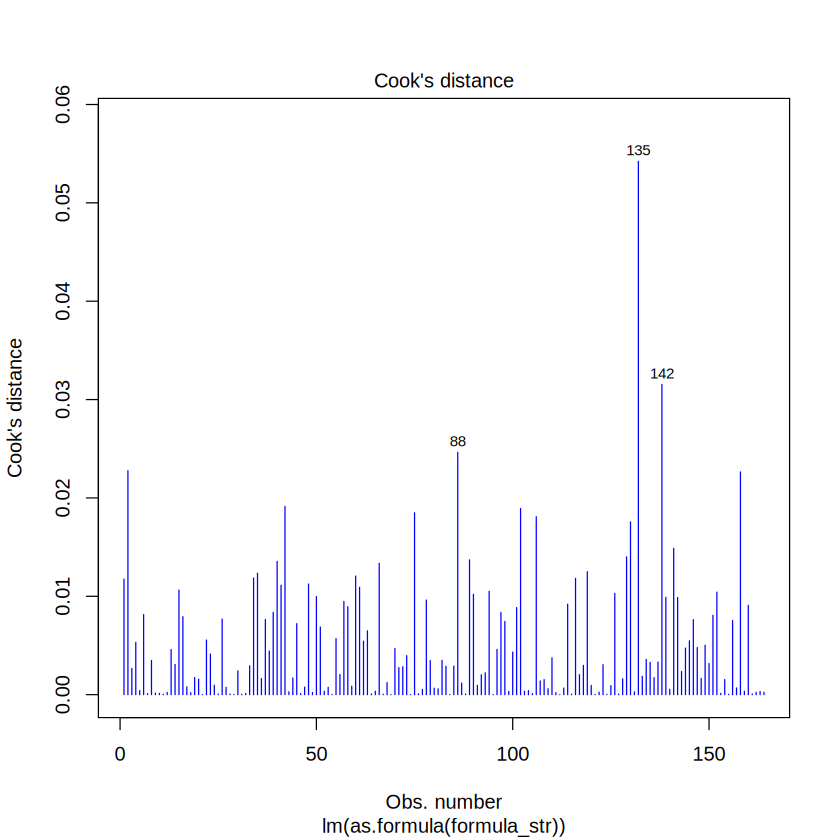

In [79]:
plot(best_model_csm.4, which=4, col=c("blue"))

In [80]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_csm.4)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_csm.5 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_csm.5)

# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm.5))

# Breusch-Pagan Test
bptest(best_model_csm.5)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-682.88 -153.23   40.03  195.81  536.21 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -156.496    148.262  -1.056 0.292752    
Ratings       74.529     21.239   3.509 0.000582 ***
Dislikes      28.856      4.691   6.152 5.78e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 258.5 on 162 degrees of freedom
Multiple R-squared:  0.2264,	Adjusted R-squared:  0.2168 
F-statistic:  23.7 on 2 and 162 DF,  p-value: 9.339e-10



	Shapiro-Wilk normality test

data:  residuals(best_model_csm.5)
W = 0.97766, p-value = 0.009073



	studentized Breusch-Pagan test

data:  best_model_csm.5
BP = 5.2443, df = 2, p-value = 0.07265


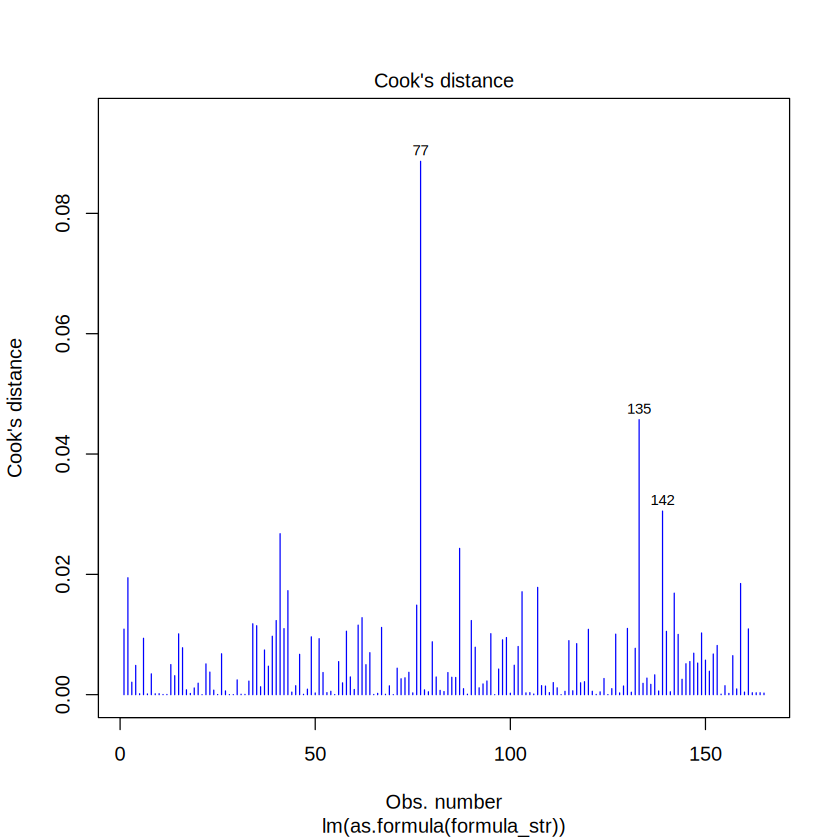

In [81]:
plot(best_model_csm.5, which=4, col=c("blue"))

### Dự đoán và đánh giá kết quả

[1] 197.5292

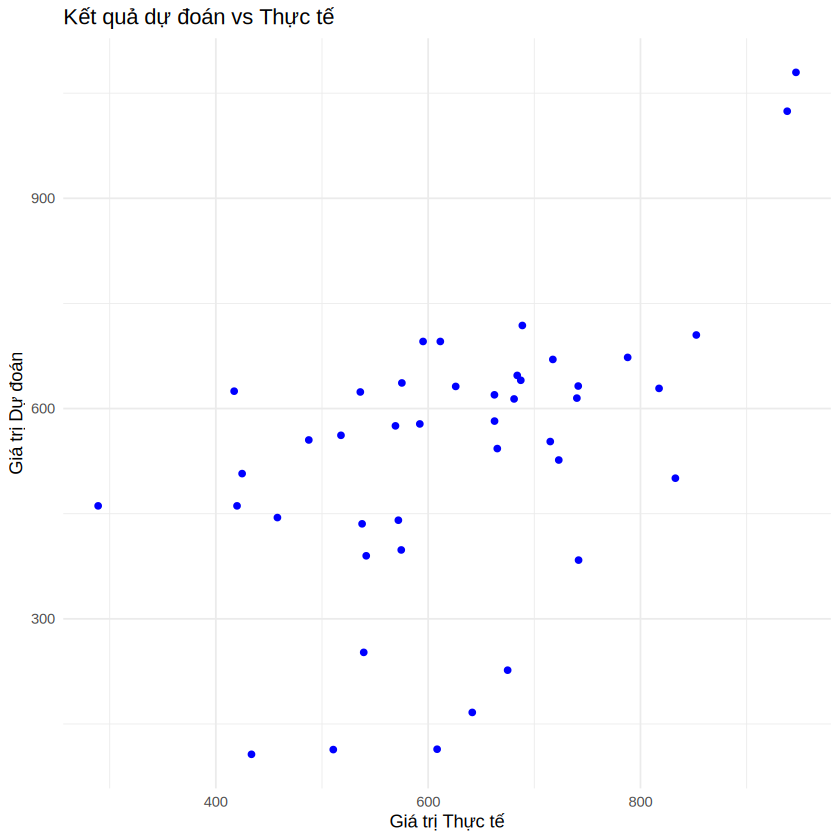

In [82]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_csm, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

[1] 203.2062

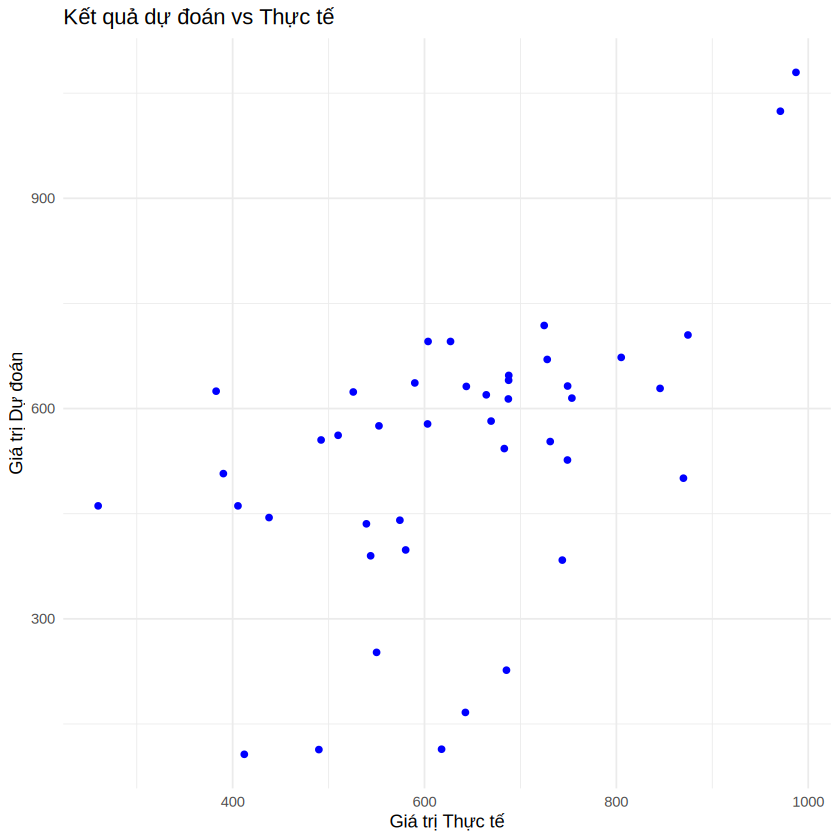

In [83]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_csm.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

[1] 196.8294

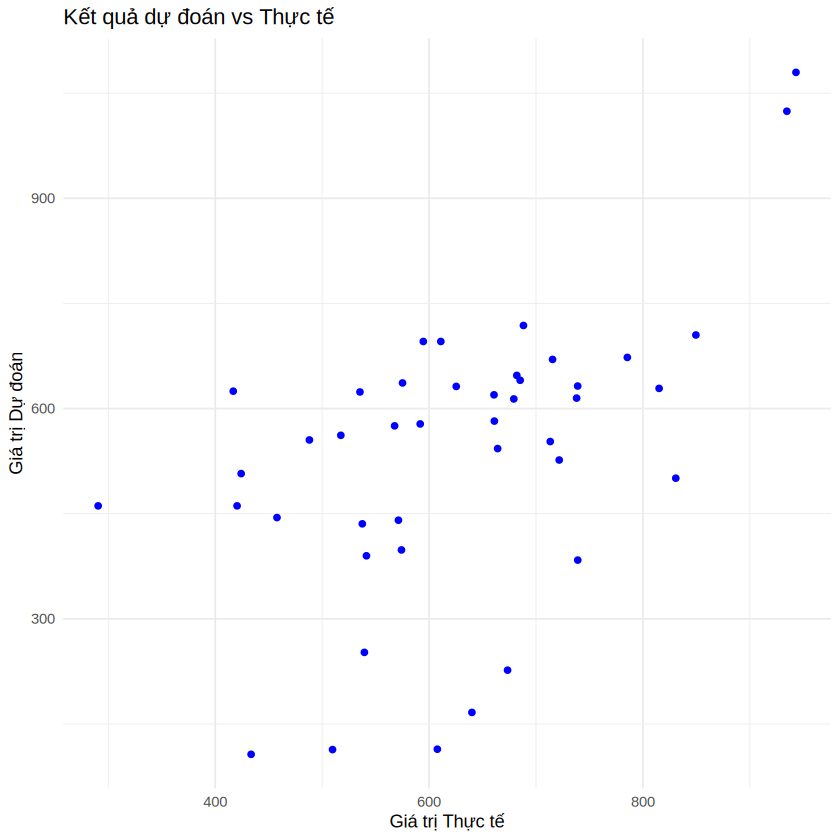

In [84]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_csm.3, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

[1] 202.0298

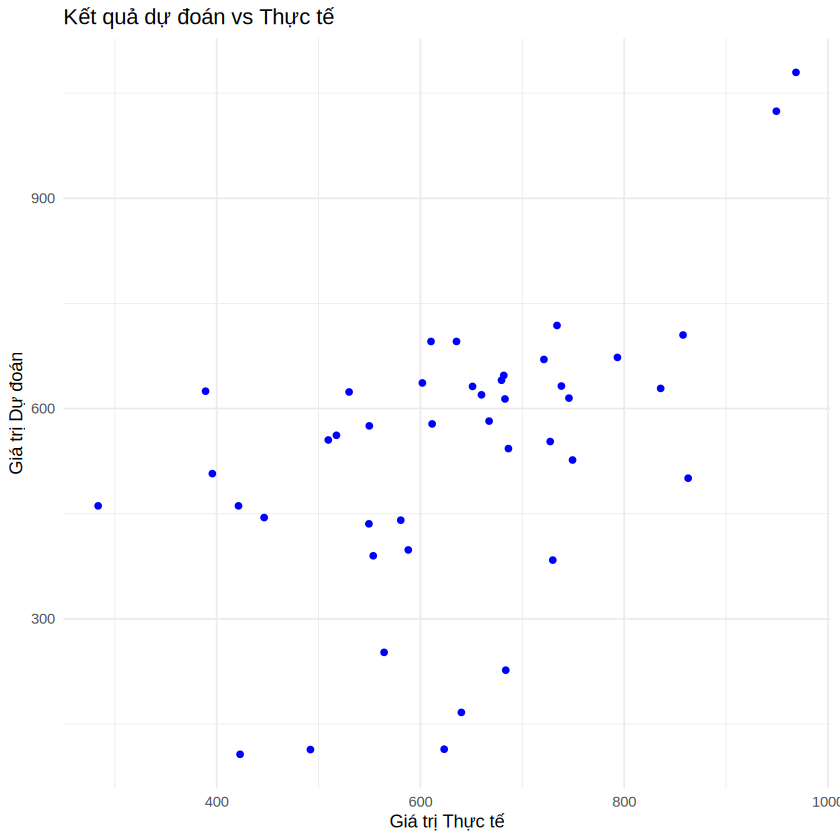

In [85]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_csm.4, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

[1] 198.0229

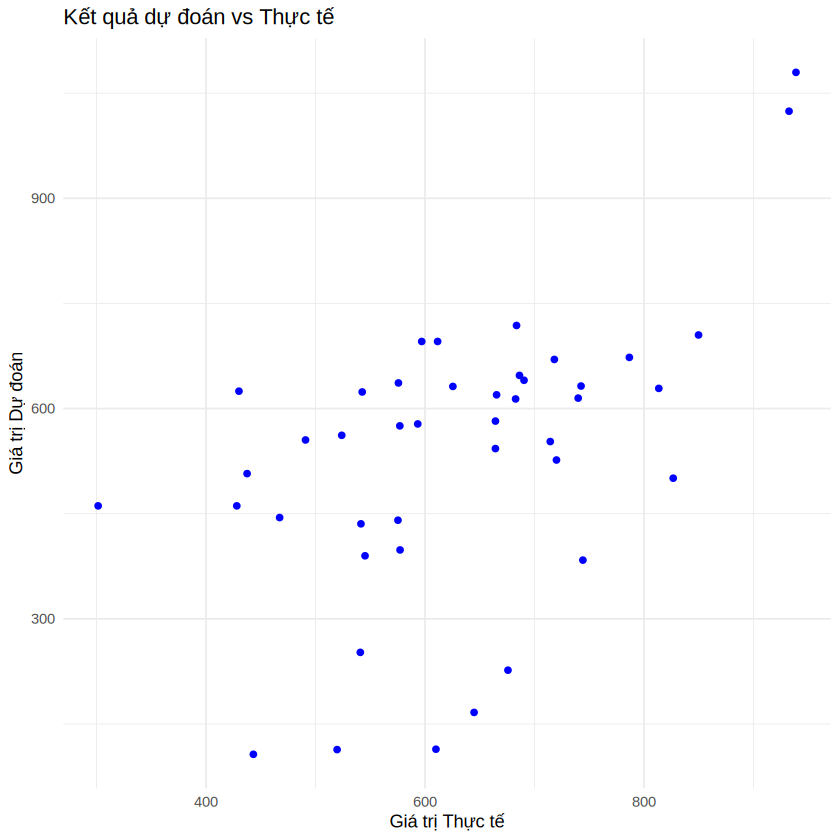

In [86]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_csm.5, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

## Mô hình hóa bằng PCR

[1] "Ratings"
[1] "Genre"
[1] "Gross"
[1] "Budget"
[1] "Screens"
[1] "Sequel"
[1] "Sentiment"
[1] "Views"
[1] "Likes"
[1] "Dislikes"
[1] "Comments"
[1] "AggregateFollowers"


### Chuẩn bị dữ liệu

In [102]:
f <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(processed_data_final))
    {
        col.name <- name

        # Extract the response variable
        response_variable <- df[[col.name]]
        
        # Ensure the response variable is numeric
        if (!is.numeric(response_variable)) {
            stop("The column to be transformed must be numeric.")
        }
        
        # Check if the column has any negative or zero values
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Apply Box-Cox transformation and find the optimal lambda
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Apply the Box-Cox transformation
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Replace the original column with the transformed values
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

processed_data <- f(processed_data_final)

[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"
[1] "Optimal lambda: 0.2"


In [103]:
split_ratio <- 0.8
split_index <- floor(nrow(processed_data) * split_ratio)

train = processed_data[1:split_index,]
test = processed_data[(split_index + 1):nrow(processed_data),]

### Khớp mô hình

In [104]:
pcr_model <- pcr(`Gross` ~ ., data = train, scale = TRUE, validation = "CV") # Fit PCR model with cross-validation

In [105]:
summary(pcr_model)

Data: 	X dimension: 180 11 
	Y dimension: 180 1
Fit method: svdpc
Number of components considered: 11

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV            60.5    51.46    40.23    40.02    40.11    37.24    36.67
adjCV         60.5    51.42    40.21    39.95    40.05    36.80    36.61
       7 comps  8 comps  9 comps  10 comps  11 comps
CV       36.01    35.93    36.01     35.87     36.56
adjCV    35.93    35.84    35.92     35.76     36.41

TRAINING: % variance explained
       1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X        37.36    54.82    65.81    74.86    82.14    88.85    94.77    97.57
Gross    28.38    56.82    58.34    58.57    65.86    66.02    67.12    67.61
       9 comps  10 comps  11 comps
X        98.81     99.53    100.00
Gross    67.66     68.04     68.55


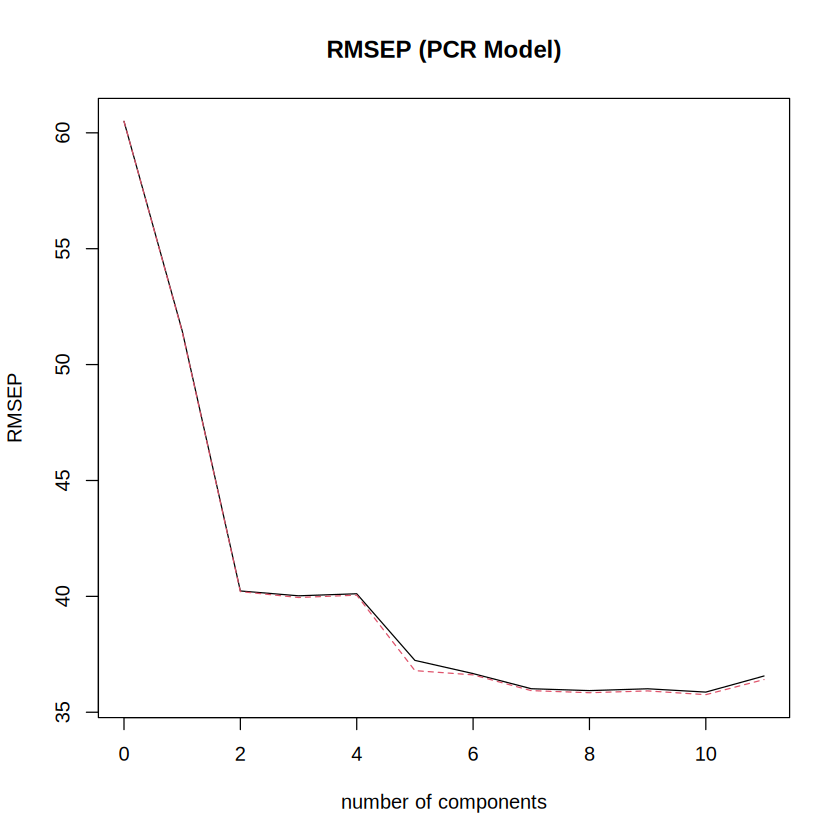

In [106]:
validationplot(pcr_model, val.type = "RMSEP", main = "RMSEP (PCR Model)")

In [107]:
optimal_number_of_components <- 8  # Optimal number of components based on the RMSEP plot and summary
predictions <- predict(pcr_model, ncomp = optimal_number_of_components, newdata = test)  

### Dự đoán và đánh giá

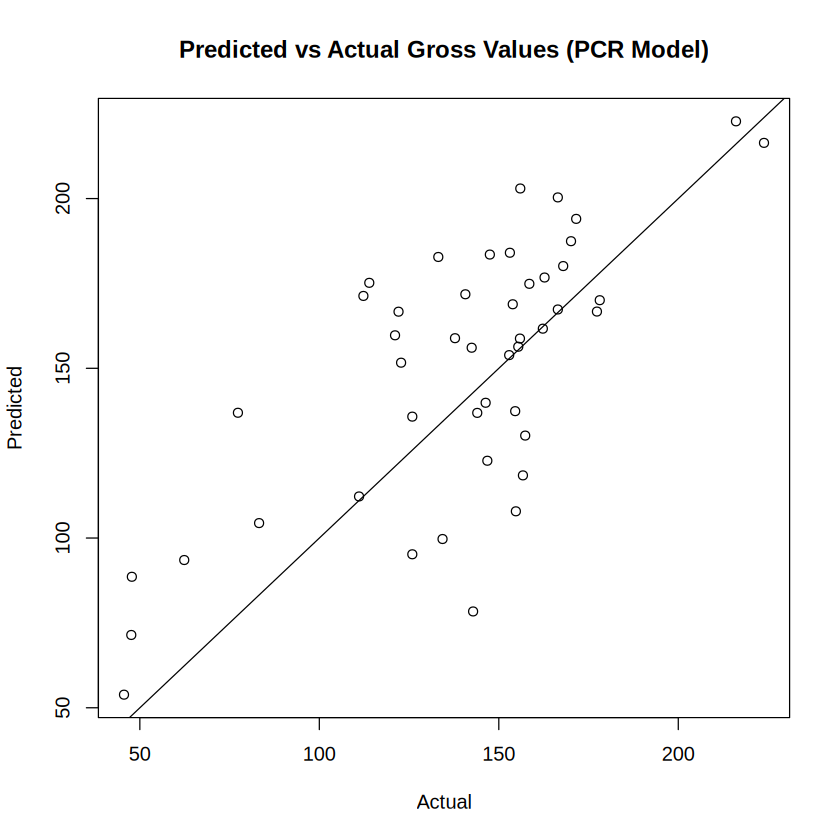

In [111]:
plot(test$`Gross`, predictions, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual Gross Values (PCR Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [109]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`Gross` - predictions)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 

[1] "RMSE:  30.2877187681928"


In [110]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`Gross` - predictions)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`Gross` - mean(test$`Gross`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.364712254945926"


## Mô hình hóa bằng PLS

### Khớp mô hình

In [118]:
pls_model <- plsr(`Gross` ~ ., data = train, scale = TRUE, validation = "CV") # Fit PLS model with cross-validation

summary(pls_model)

Data: 	X dimension: 180 11 
	Y dimension: 180 1
Fit method: kernelpls
Number of components considered: 11

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV            60.5    41.27    36.33    35.89    36.42    37.05    37.14
adjCV         60.5    41.24    36.28    35.81    36.30    36.87    36.96
       7 comps  8 comps  9 comps  10 comps  11 comps
CV       37.12    37.16    37.12     37.12     37.12
adjCV    36.93    36.97    36.93     36.93     36.94

TRAINING: % variance explained
       1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X        33.46    53.45    62.24    70.41    75.28    79.64    84.16    91.31
Gross    54.86    65.58    67.69    67.95    68.25    68.43    68.52    68.54
       9 comps  10 comps  11 comps
X        92.69     98.75    100.00
Gross    68.55     68.55     68.55


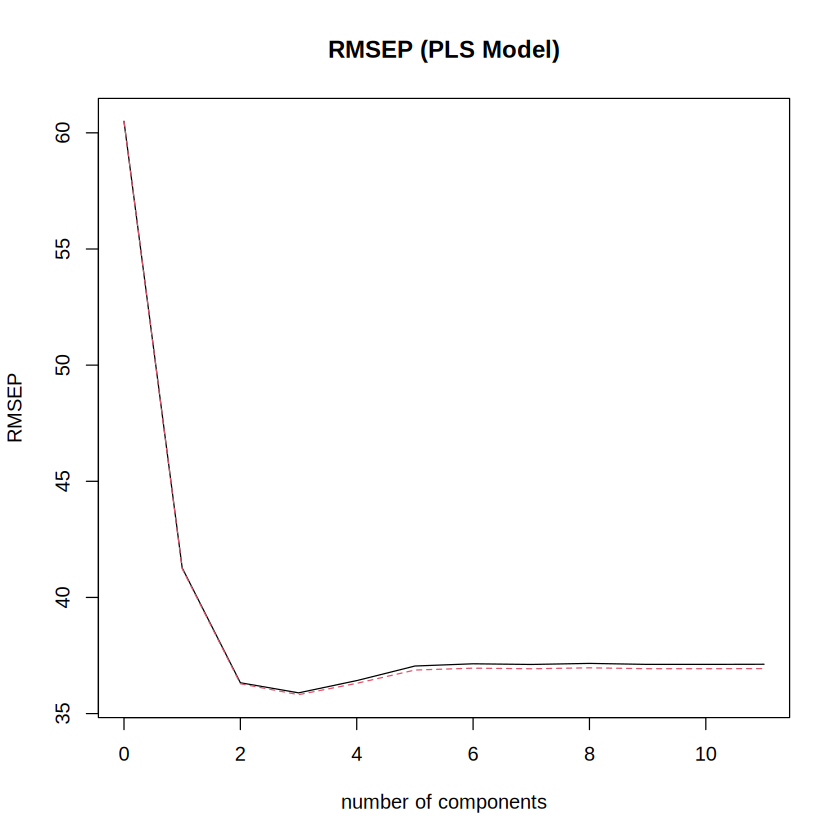

In [119]:
# Plotting the RMSEP (Root Mean Squared Error of Prediction) to find the optimal number of components
validationplot(pls_model, val.type = "RMSEP", main = "RMSEP (PLS Model)")

### Dự đoán và đánh giá

In [120]:
# Predict using the model and evaluate on the test set with optimal number of components
optimal_number_of_components <- 3  # Optimal number of components based on the RMSEP plot and summary
predictions2 <- predict(pls_model, ncomp = optimal_number_of_components, newdata = test)

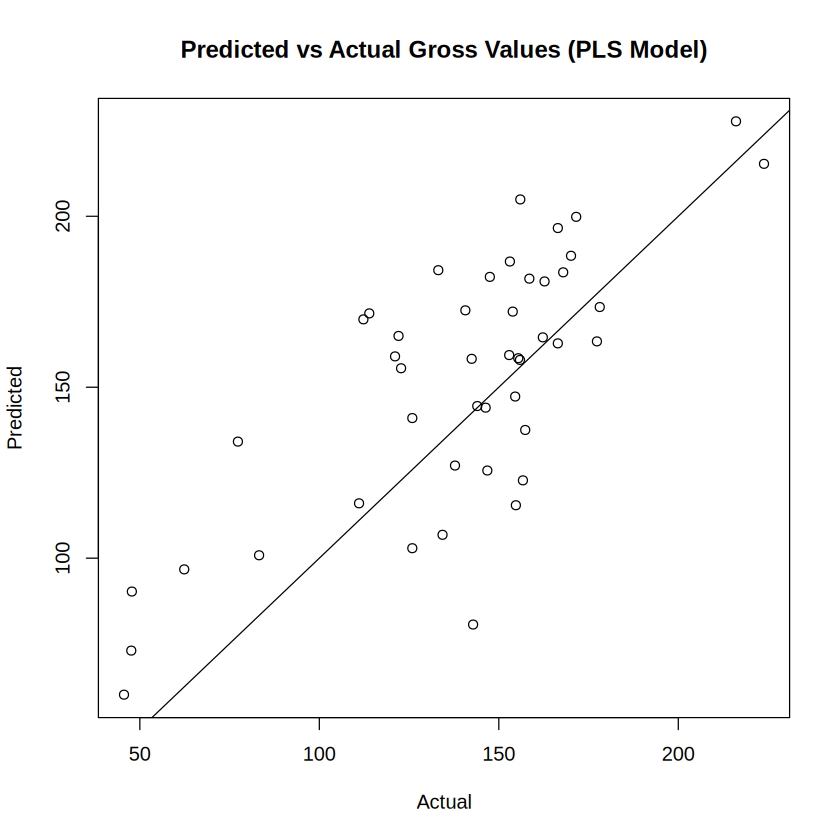

In [121]:
# Compare predictions with actual values
plot(test$`Gross`, predictions2, xlab = "Actual", ylab = "Predicted", main = "Predicted vs Actual Gross Values (PLS Model)")  # Plot actual vs predicted values
abline(0, 1)  # Add a diagonal line for reference

In [123]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((test$`Gross` - predictions2)^2))  # Calculate RMSE between actual and predicted values
print(paste("RMSE: ", rmse)) 

[1] "RMSE:  29.5211569811326"


In [124]:
# Calculate the sum of squares of residuals
ss_res <- sum((test$`Gross` - predictions2)^2)

# Calculate the total sum of squares
ss_tot <- sum((test$`Gross` - mean(test$`Gross`))^2)

# Calculate R-squared
r_squared <- 1 - (ss_res / ss_tot)

# Print R-squared
print(paste("R-squared: ", r_squared))

[1] "R-squared:  0.396462724648206"


## So sánh hai mô hình PCR và PLS

## Kết luận